# Курсовая работа № 2
## Аналитика. Начальный уровень

Курсовая работа состоит из двух частей – обязательной и дополнительной. **Для зачета необходимо выполнение только первой части.** Выполнение второй части может потребовать дополнительные знания Python.

- [Часть первая](#Часть-первая)
- [Часть вторая](#Часть-вторая)

## Часть первая


Перед вами стоит задача – подготовить аналитический отчет для HR-отдела. На основании проведенной аналитики предполагается составить рекомендации для отдела кадров по стратегии набора персонала, а также по взаимодействию с уже имеющимися сотрудниками.
<br><br> В базе данных лежит набор таблиц, которые содержат данные о сотрудниках вымышленной компании.
Сделайте обзор штата сотрудников компании. Составьте набор предметов исследования, а затем проверьте их на данных. Вся аналитика должна быть выполена с помощью SQL. Впоследствии данные можно визуализировать, однако финальные датафреймы для графиков также должны быть подготовлены с помощью SQL. <br><br>

Примеры гипотез:
1. Есть зависимость между `perfomance score` и тем, под чьим руководством работает сотрудник.
2. Есть зависимость между продолжительностью работы в компании и семейным положением сотрудника.
2. Есть зависимость между продолжительностью работы в компании и возрастом сотрудника.

<br><br>
Параметры для подключения следующие: хост – `dsstudents.skillbox.ru`, порт – `5432`, имя базы данных – `human_resources`, пользователь – `readonly`, пароль – `6hajV34RTQfmxhS`. Таблицы, доступные для анализа, – `hr_dataset`, `production_staff`, `recruiting_costs`, `salary_grid`.

In [1]:
### YOUR CODE HERE ###





## Часть вторая

Перед вами стоит задача – подготовить аналитический ответ для SMM-отдела компании Skillbox. <br> Объектом анализа является  [паблик Skillbox Вконтакте](https://vk.com/skillbox_education). <br> <br> 
Подключитесь к  API VK и выгрузите посты со стены паблика Skillbox за интересующий период (определите самостоятельно и обоснуйте). Проанализируйте влияние различных факторов (например, времени публикации) на вовлеченность пользователей (количество лайков, комментариев, голосов в опросах). Сделайте аналитику по рубрикам (примеры рубрик: дизайн-битва, игра по управлению), которые есть в паблике. Выбрать нужные посты можно с помощью регулярных выражений. Составьте перечень рекомандаций для SMM-отдела по итогам анализа. <br> <br> 

Дополнительные инструкции по работе с API VK расположены [здесь](https://colab.research.google.com/drive/1rRaTay-OSPLAOX8V9UaFvTiAciVtp2s3).

## 2.0 Подготовка данных ###

In [2]:
import requests # v. 2.27.1
import re
from bs4 import BeautifulSoup # v. 4.11.1
import pymorphy2 # v. 0.9.1
import urllib.request as req
import json
import datetime as dt
import time
import numpy as np # v. 1.21.2
from scipy import stats # v. 1.7.1
import pandas as pd  # v. 1.3.4
import matplotlib as mpl  # v. 3.5.0
import matplotlib.pyplot as plt  # v. 3.5.0
import seaborn as sns  # v. 0.11.2


In [3]:
pd.set_option('display.max_rows', 400)  # изменим максимум отображаемых строк 
pd.set_option('display.max_columns', 50)  # изменим максимум отображаемых столбцов 

In [4]:
sns.set_style("whitegrid") # определим стиль графиков seaborn по умолчанию

In [5]:
# функция для получения данных через API ВК (Соглано инструкции к заданию)
def getjson(url):
    response = requests.get(url)
    response = response.json()
    return response

In [6]:
## полученный от ВК token (Согласно иструкции к заданию), 
## сразу приведём его к строковому формату (чтобы избежать возможных ошибок)
#vk_token = 'there was a token here' 

**ОБОСНОВАНИЕ ПЕРИОДА ДЛЯ ВЫБОРКИ ДАННЫХ**  
Определим для исследования промежуток времени с начала 4-го квартала (00:00:00 01 октября 2021 года) 2022 по 23:59:59 30 апреля 2022 года (кратный месячный промежуток, включающий дату начала работы над аналитической частью 2-го раздела курсовой).
В этот период попадает: подготовка к новому году, сезон новогодних скидок, окончание пандемии, начало специальной военной операции на Украине и санкционная война. Эти факторы сильно повлияли на рынок труда и образовательных услуг, нашли ли они отражение в работе SMM отдела?

Приведём указанные даты к формату POSIX.


In [7]:
d1 = "30/04/2022 23:59:59"
d0= "01/10/2021 00:00:00"

date0 = int(time.mktime(dt.datetime.strptime(d0, "%d/%m/%Y %H:%M:%S").timetuple()))
date1 = int(time.mktime(dt.datetime.strptime(d1, "%d/%m/%Y %H:%M:%S").timetuple()))


In [8]:
# Создадим функцию формирования строки запроса API - сложение строки из составных частей url запроса
def my_request(method='', params='', access_token='', offset=0, count=1):
    my_url_=f"https://api.vk.com/method/{method}" + f"?{params}" + f"&access_token={access_token}" + \
    f"&owner_id=-66669811" + f"&offset={offset}" + f"&count={count}" + "&v=5.92"   
    return my_url_


In [9]:
## Создадим DF из самой новой (послденей) записи в данных
#my_url=my_request('wall.get','post_id=232702', vk_token, 0, 1)
#response = getjson(my_url)

In [10]:
#df_main = pd.json_normalize(response['response']['items'])
##df_main

При подборе сообщений по дате надо исключить закреплённые сообщения. (Столбец is_pinned=1) 

In [11]:
## Создадим цикл для выбора нужных нам данных по датам
#control_date = date1 # переменная для контроля даты в получаемых данных. Для начала - конец периода выборки
#my_offset = 1 # одна запись в основном DF уже есть, следовательно начинаем со сдвига на одну запись.
#my_count = 20 # будем выбирать по 20 записей за проход.
#
## сравниваем контрольную дату с датой начала выборки и с датой закреплённого сообщения.
#while date0 <= control_date <= date1: 
#    # Выведем данные запроса на основании вызова созданной функции
#    my_url=my_request('wall.get','post_id=232702', vk_token, my_offset, my_count)
#    response = getjson(my_url)
#
#    # получим текущий df из результата запроса и присоединим его к основному DF
#    df_current = pd.json_normalize(response['response']['items'])
#
#    frames = [df_main, df_current] # список df, необходимый для pd.concat(objs=)
#    df_main = pd.concat(frames, ignore_index=True)
#    
#    # Обновим контрольные значения
#    control_date = df_main[df_main.is_pinned != 1].date.min() # минимальная дата, кроме закреплённых сообщений
#    my_offset += my_count # увеличиваем сдвиг на количество уже прочитаных записей.
#
##df_main


Отсечём записи с датами меньшими и большими чем начальная дата. Мы за один проход загружали по 20 записей, сюда могли попасть лишние записи. Более того, в процессе отладки, в DF могли попасть записи за более поздние даты, чем определено в исследуемом периоде.

In [12]:
#df_main=df_main[(df_main.date >= date0) & (df_main.date <= date1)]
##df_main


In [13]:
## сохраним основной DF в формате .csv чтобы больше не обращаться к записям в VK и не использовать токен.
#df_main.to_csv('df_main.csv')


Теперь токен можно удалить (он всё равно имеет срок действия 24 часа)

In [14]:
# загрузим df_main из файла df.csv, далее работать будем уже с ним.
df_main = pd.read_csv('df_main.csv')


In [15]:
# Уберём NaN-ы в столбце "text" - они там есть.
df_main = df_main.dropna(subset=["text"])


In [16]:
df_main.head(2)


,Unnamed: 0,id,from_id,owner_id,date,marked_as_ads,is_favorite,post_type,text,is_pinned,attachments,hash,post_source.type,comments.can_post,comments.count,comments.groups_can_post,likes.can_like,likes.count,likes.user_likes,likes.can_publish,reposts.count,reposts.user_reposted,views.count,post_source.platform,copy_history
0,0,215343,-66669811,-66669811,1635762751,0,False,post,"Нет, это не шутка! Попробовать 34 курса и инте...",1.0,"[{'type': 'photo', 'photo': {'album_id': -7, '...",0jU4pxE0B2VTkCP8w03smbIMLA,vk,1,360,True,1,1253,0,1,1872,0,179368,NaN,NaN
1,12,244472,-66669811,-66669811,1651309108,0,False,post,"Для всех дизайнеров, которые хотят сами себе р...",NaN,"[{'type': 'photo', 'photo': {'album_id': -7, '...",C2NRV1aU4tIbr8ulnKvyrrbSEQ,api,1,2,True,1,21,0,1,22,0,11420,NaN,NaN


Создадим рабочий DF, сохранив в нём только нужные для анализа столбцы, преобразуем дату и время, изменим заголовки столбцов и индекс.

In [17]:
# определим нужные столбцы
df_work = df_main[["id", "date", "text", "comments.count", "likes.count",  "reposts.count", "views.count"]]

# добавим столбцы для даты, времени (в часах); преобразуем дату в дни и часы по отдельным столбцам (приведем к datetime)
df_work = df_work.assign(
    dates = df_work["date"].apply(lambda x: pd.to_datetime(dt.datetime.fromtimestamp(x).strftime('%Y-%m-%d'))))
df_work = df_work.assign(
    hours = df_work["date"].apply(lambda x: dt.datetime.fromtimestamp(x).strftime('%H')))

# добавим столбцы для дня недели, в вербальном и ISO обозначении, 
df_work = df_work.assign(
    weekday = df_work["date"].apply(lambda x: dt.datetime.fromtimestamp(x).strftime('%A')))
df_work = df_work.assign(
    weekday_num = df_work["date"].apply(lambda x: dt.datetime.fromtimestamp(x).isoweekday()))

# уберём столбец date (формат POSIX больше не нужен)
df_work.drop("date", axis='columns', inplace=True)

# переименуем столбцы для удобства обращения 
df_work=df_work.rename(columns={"id":"post_id",
                        "comments.count":"comments_count", 
                        "likes.count":"likes_count", 
                        "reposts.count":"reposts_count",
                        "views.count":"views_count"})

# изменим порядок столбцов
df_work = df_work.reindex(
    columns=['post_id', 'dates','hours', 'weekday', 'weekday_num', 'text', 
             'views_count', 'comments_count','likes_count','reposts_count'])

# изменим столбец индекса
#df_work = df_work.set_index("id")

df_work.sample(5)


,post_id,dates,hours,weekday,weekday_num,text,views_count,comments_count,likes_count,reposts_count
23,242931,2022-04-19,17,Tuesday,2,"В последнее время все только и говорят о том, ...",90314,3,37,15
269,211069,2021-10-07,15,Thursday,4,"Невозможное — возможно, а полезное — нужно обя...",13955,0,32,6
27,242591,2022-04-16,12,Saturday,6,А ссылочку на портфолио можно?\n\nСегодня хоти...,18896,2,108,66
280,210224,2021-10-04,10,Monday,1,Все мы совершаем ошибки! Но одно дело — неправ...,27568,0,54,20
36,241486,2022-04-10,11,Sunday,7,"Все мы знаем, что случится в конце пьесы с руж...",16342,9,25,6


## 2.1. Формальный анализ данных ##

### 2.1.1. Временное распределение публикаций и реакций пользователей на них ###

#### 2.1.1.1. Хронология публикаций и реакций пользователей ####
>**ПРИМЕЧАНИЕ**  
>1. Следует понимать, что *данные о количестве публикаций относятся к датам*. В то же время данные о просмотрах реакции пользователей (комментарии, "лайки", репосты) относятся не к датам, когда они совершены, а к конкретным публикациям. Следовательно, *данные просмотрах и о реакции пользователей относятся к датам соответствующих публикаций*.  
>2. В построенном ниже графике данные о распределении публикаций по дням подразумевают вычисление средней хронологической о количестве публикаций в день, и медианы, с учётом дней, когда публикаций не было вообще. В отличие от этого, графики распределения просмотров и реакций пользователей по дням публикаций подразумевают подсчёт среднего количества реакций на одну публикацию, и соответствующего медианного количества реакций.
>3. Просмотры и реакции пользователей не обязательно происходят в день публикации, а могут происходить в любое время после, влияя на показатели каждой конкретной публикации даже через большой промежуток времени после опубликования.


In [18]:
# Cоздажим DF для работы с графиками в данном пункте
# Произведём сортировку и аггрегацию по дням
df_111 = df_work.groupby("dates", as_index=False)\
.agg({'text':'count', 'views_count':['sum'], 'comments_count':['sum'], 'likes_count':['sum'], 'reposts_count':['sum']})
# Уберём мультиндекс в столбцах
df_111 = df_111.droplevel(level=1, axis=1)
# Переименуем столбцы по смыслу
df_111 = df_111.rename(columns={'text':'posts_count'})
df_111.sample(5)

,dates,posts_count,views_count,comments_count,likes_count,reposts_count
122,2022-02-09,2,26238,3,57,18
69,2021-12-11,1,35191,0,342,260
67,2021-12-09,1,19663,0,42,17
8,2021-10-10,1,20387,8,54,14
77,2021-12-19,1,32381,23,224,152


**Важное замечание для построения временных графиков**: df_111 агрегирован по датам.

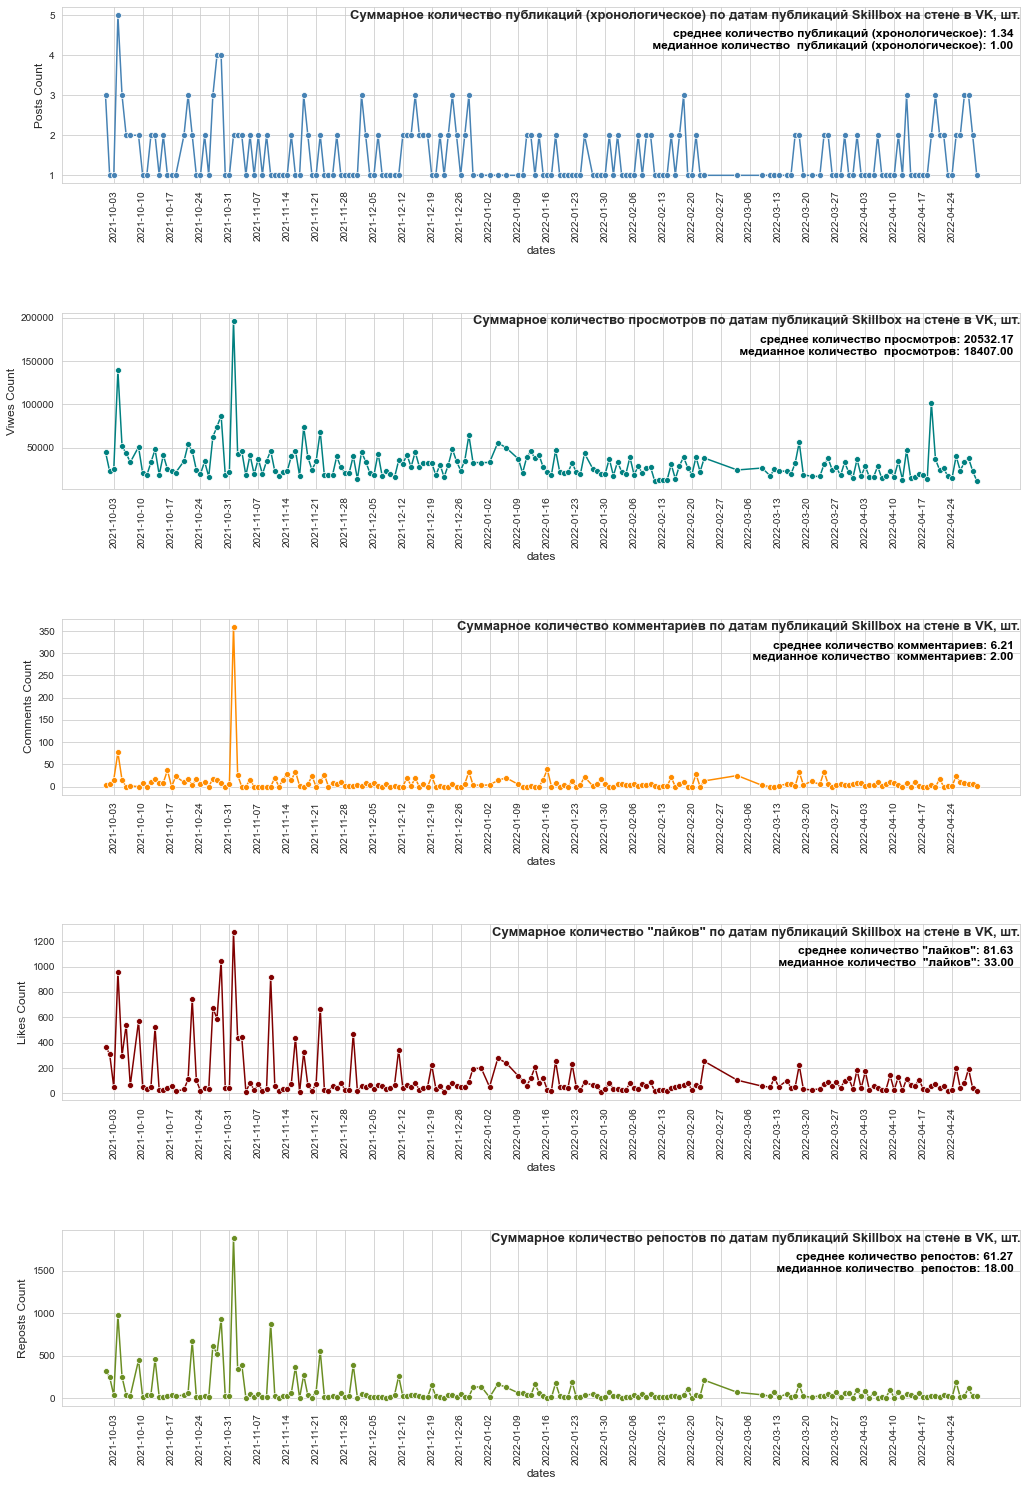

In [19]:
# Построим 5 графиков сразу в цикле
# Создадим список параметров

param_list=[('posts_count', 'steelblue', 'публикаций (хронологическое)', 'Posts'),
            ('views_count', 'teal', 'просмотров', 'Viwes'),
            ('comments_count', 'darkorange', 'комментариев', 'Comments'),
            ('likes_count', 'maroon', "\"лайков\"", 'Likes'), 
            ('reposts_count', 'olivedrab', "репостов", 'Reposts')]

fig, ax = plt.subplots(figsize=(14, 20), ncols=1, nrows=5)
# Определим расстояния между графиками
fig.tight_layout(h_pad=11)

# Определим для шкал X общий временной диапазон в формате Pandas с недельными интервалами (для читаемости):
scale_span_x = pd.date_range(start=df_111.dates.min(),
                           end=df_111.dates.max(),
                           freq='W').tolist()

for i, param in enumerate(param_list):
    sns.lineplot(data=df_111,
                 x='dates',
                 y=param[0],
                 #height=4,
                 #aspect=3.2,
                 marker='o',
                 color=param[1],
                 ax=ax[i]
                 )
    # Определяем шкалу X для каждого графика:
    ax[i].set_xticks(ticks=scale_span_x)  # установим шкалу X и размер её обозначений 
    ax[i].xaxis.set_tick_params(rotation=90, labelsize=10)

    # изменим подпись оси X 
    ax[i].set_xlabel("dates", fontsize=12)

    # изменим подпись оси Y
    ax[i].set_ylabel(f"{param[3]} Count", fontsize=12)
    ax[i].yaxis.set_tick_params(labelsize=10) # установим размер её обозначений шкалы Y

    # Определим заголовок для каждого графика
    ax[i].set_title(
        f"Суммарное количество {param[2]} по датам публикаций Skillbox на стене в VK, шт.", 
                 fontsize=13, fontweight="bold", loc="right", y=0.9)

    # Добавим данные о средней и медиане по всей совокупности
    if i != 0:
        mean_value=df_work[param[0]].mean()
        median_value=df_work[param[0]].median()
    else: # средняя хронологическая средняя и медиана с учётом дней с 0 публикаций
        days_num=(df_111.dates.max() - df_111.dates.min()).days # количество дней в периоде
        # полусуммы значений на начало и конец периода + сумма значений между ними:
        pub_sum=df_111.posts_count.sum() - (df_111.posts_count.iloc[0]/2 + df_111.posts_count.iloc[-1]/2)
        avg_chrono=pub_sum/(days_num-1)
        mean_value=avg_chrono
        # создадим служебный DF из всех дней периода и кол-ва публикаций, включая 0, вычислим по нему медиану
        date_span_series = pd.date_range(start=df_111.dates.min(),
                                   end=df_111.dates.max(),
                                   freq='D')
        df_111dat=pd.DataFrame({"dates":date_span_series.tolist()})
        df_111dat=df_111dat.merge(df_111[["dates", "posts_count"]], on="dates", how='left').fillna(0)
        median_value=df_111dat.posts_count.median()
    # Создание подписи 
    ax[i].annotate(
        text=f"среднее количество {param[2]}: {mean_value:.2f}  \n медианное количество  {param[2]}: {median_value:.2f}  ",
        xy=(1,0.875),  # Положение подписи (чтобы не перекрывать точки графика)
        xycoords="axes fraction",
        horizontalalignment='right',  # Выравнивание текста по горизонтали
        verticalalignment='top',  # Выравнивание текста по вертикали
        rotation=None, # Поворот подписи
        color='black', # Цвет надписи
        alpha=1,
        fontsize=12,
        fontweight="bold")
#    ax[i].set_yscale('log')
plt.show()


In [20]:
no_posts = df_111dat.posts_count[df_111dat.posts_count==0].count()
yes_posts = df_111dat.posts_count[df_111dat.posts_count!=0].count()
print(f"За весь период в {no_posts+yes_posts} дней публикации Skillbox на стене в VK были в {yes_posts} днях. \n"
      f"Это значит, что в {(no_posts/(no_posts+yes_posts)*100):.0f}% дней публикации не осуществлялись.")

За весь период в 212 дней публикации Skillbox на стене в VK были в 187 днях. 
Это значит, что в 12% дней публикации не осуществлялись.


In [21]:
# Для анализа текстов при написании выводов ниже исользовался код:
#df_work.text[df_work.dates == pd.Timestamp(Y, M, D)].tolist()

**ВЫВОД**  
***Количество публикаций***
1. Размещение публикаций Skillbox на стене в VK производится не ежедневно. Но чуть менее, чем в 90% дней они осуществляются. В среднем за весь период количество публикаций в день ближе к одной, чем к двум.
2. Отмечается "затишье" в размещении публикаций в период новогодних праздников (всего 5 публикаций) и в период начала специальной военной операции на Украине и полномасштабной санкционной войны(с 24 февраля по 7 марта 2022 года - только 1 публикации). Со второй недели марта, возможно, с наступлением периода снятия ковидных ограничений, публикации вновь становятся ежедневными. Если приостановка публикаций в конце февраля - начале марта 2022 года может быть объяснена политическими причинами, то снижение интенсивности публикаций в период новогодних праздников, когда читатели имеют больше времени, чтобы получать информацию из Интернета, представляется странным. Также, в период посленовогодних скидок, интенсивность публикаций могла бы быть выше (здесь нет дней, когда публиковалось более 2 публикаций).
3. На протяжении всего периода отмечается уменьшение количества публикаций в день. При том, что в большую часть дней осуществляется не более одной публикации, в 2022 году нет дней, когда было сделано 4 и более публикации, в 4-м квартале 2021 года таких дней было 3. По 3 публикации в день приходится на 9 дней 4-го квартала 2021 года и на 4 дня из четырёх месяцев 2022 года.

***Количество просмотров по датам публикаций***  
1. Количество просмотров измеряется десятками тысяч и, в основном, колеблется между 10 и 50 тысячами. Медианные и средние значения просмотров близки друг к другу. Есть несколько выбросов. 
2. Исходя из особенностей подсчёта просмотров по публикациям (описаны в примечании к данному пункту выше), самое маленькое число просмотров приходится на самую последнюю публикацию. 
3. В данном конкретном случае выбросы по количеству просмотров вряд ли стоит отбрасывать, а, наоборот, следует изучить их подробнее и, по возможности, выявить закономерности: 
- 04.10.2021 - общее количество просмотров более 125 тысяч - связано с большим количеством публикаций (5) в этот день;
- 28.10.2021 - общее количество просмотров около 75 тысяч - связано с большим количеством публикаций (4) в этот день
- 29.10.2021 - общее количество просмотров около 90 тысяч - аналогичные причины
- 01.11.2021 - общее количество просмотров почти 180 тысяч на 2 публикации - здесь очень привлекательные темы: *бесплатный* недельный доступ к курсам и *бесплатные* трёхдневные вебинары; более того, первая из этих двух тем закреплена и автоматически набирает просмотры при каждом входе на стену Skillbox;
- 18.11.2021 - общее количество просмотров около 75 тысяч - три публикации и одна из них - *бесплатный* курс;
- 22.11.2021 - общее количество просмотров около 70 тысяч - всего 2 публикации и одна из них снова - *бесплатный* курс;
- 28.12.2021 - общее количество просмотров около 60 тысяч - 3 публикации, одна из них о новогодней распродаже;
- 04.01.2022 - общее количество просмотров более 50 тысяч - ничего особенного в публикации, скорее всего пользователи заходили в новогодние праздники, чтобы получить информацию, однако информационная насыщенность сообщения близка к 0;
- 06.01.2022 - общее количество просмотров около 50 тысяч - аналогичная ситуация;
- 18.03.2022 - общее количество просмотров более 50 тысяч - 2 публикации, на первый взгляд ничем особенным не выделяющиеся, возможно, одна из публикаций говорит о вариантах замены заблокированных популярных сервисов;
- 19.04.2022 - общее количество просмотров более 100 тысяч - 2 публикации: на тему карьеры и трудоустройства и на тему бонусной программы, возможно, большое количество просмотров связано с повышенным интересом к трудоустройству в условиях неопределённости и сложностей в экономике.
4. Подытог: наибольшее количество просмотров (помимо дней, когда было много публикаций), относятся к публикациям с обещанием бесплатных курсов, вебинаров, программ, а также бонусов и распродаж; еще одна группа причин: высокая актуальность темы; третья группа - свободное время у пользователей для просмотра новой информации, которое, как мне представляется недостаточно эффективно использовалось. Искусственно увеличивается количество просмотров у закреплённых тем. Нельзя исключать, что просмотры могут также "накручиваться" программным образом.

***Количество комментариев по датам публикаций***  
1. Количество комментариев колеблется между 0 и 10. Средствами Pandas несложно подсчитать что на 52 даты или 28% из 185 дней с публикациями не приходится ни одного комментария. В целом уровень комментариев очень низкий. Исключения здесь очень резкие:
- 04.10.2021 - около 75, причины, скорее всего в большом количестве публикаций за день;
- 01.11.2021 - около 350 комментариев причины, как и в количестве просмотров, темы о бесплатном, и одна из них закреплена; если обратиться непосредственно к стене Skillbox в VK, можно заметить очень большое число негативных комментариев.

***Количество "лайков" и репостов***  
1. Эти два графика практически идентичны по форме (за несколькими незаметными исключениями). Это вполне закономерно: пользователь скорее поделится публикацией, которая ему понравилась.
2. Общая динамика этих графиков схожа с графиком просмотров. Однако пиковые значения здесь могут быть выражены в иной степени: где-то они больше, где-то меньше, есть дополнительные пиковые значения:
- 04.10.2021 - общее количество "лайков" и репостов около 1000 в обоих случаях - связано с большим количеством публикаций (5) в этот день;
- 22.10.2021 - чуть менее 800 "лайков" и 750 репостов - причина, возможно, в тематике - приёма макияжа;
- 28.10.2021 - 600 и 500, соответственно, возможные причины указаны выше;
- 29.10.2021 - чуть более 1000 и чуть менее 1000 - возможные причины - так же, указаны выше;
- 01.11.2021 - синхронный пик - более 1200 "лайков" и более 1750 репостов - причины уже указаны выше;
- 10.11.2021 - около 950 и 800, соответственно - причины на данном этапе сложно определить;
- 22.11.2021 - около 700 и чуть выше 500 - причины указаны выше;
- 30.11.2021 - около 500 и около 450 - причины на данном этапе сложно определить;
- 11.12.2021 - чуть мене 450 и около 250 - возможно, предложения для новогодних подарков;
- 19.12.2021 - около 200 в обоих случаях - причины на данном этапе сложно определить.
3. Очень высокие пиковые значения по сравнению с графиком просмотров сходят на нет к началу 2022 года. В 2022 году графики становятся идентичными графику просмотров.

*На всех графиках чётко видно постепенное снижение активности в течение 4-го квартала 2021 года, некоторое оживление в посленовогодний период, пауза в первые 10 дней с момента начала специальной военной операции, оживление с середины марта до настоящего времени, возможно, связанное с ослаблением ковидных ограничений.*


#### 2.1.1.2. Распределение дней публикаций и реакций на них пользователей по дням недели ####

In [22]:
# Cоздажим DF для работы с графиками в данном пункте
# Произведём сортировку и аггрегацию по дням недели
df_112 = df_work.groupby(["weekday", "weekday_num"], as_index=False)\
.agg({'text':['count'], 'views_count':['sum'], 'comments_count':['sum'], 'likes_count':['sum'], 'reposts_count':['sum']})
# Уберём мультиндекс в столбцах
df_112 = df_112.droplevel(level=1, axis=1)
# Переименуем столбцы по смыслу
df_112 = df_112.rename(columns={'text':'posts_count'})
# Остортируем записи по порядоквому номеру дня недели
df_112.sort_values("weekday_num", inplace=True)
#df_112

In [23]:
# для построения графиков уберём поле с номерами дней недели и развернём таблицу в long-data формат
data2 = df_112.drop("weekday_num", axis='columns').melt(id_vars="weekday")
#data2

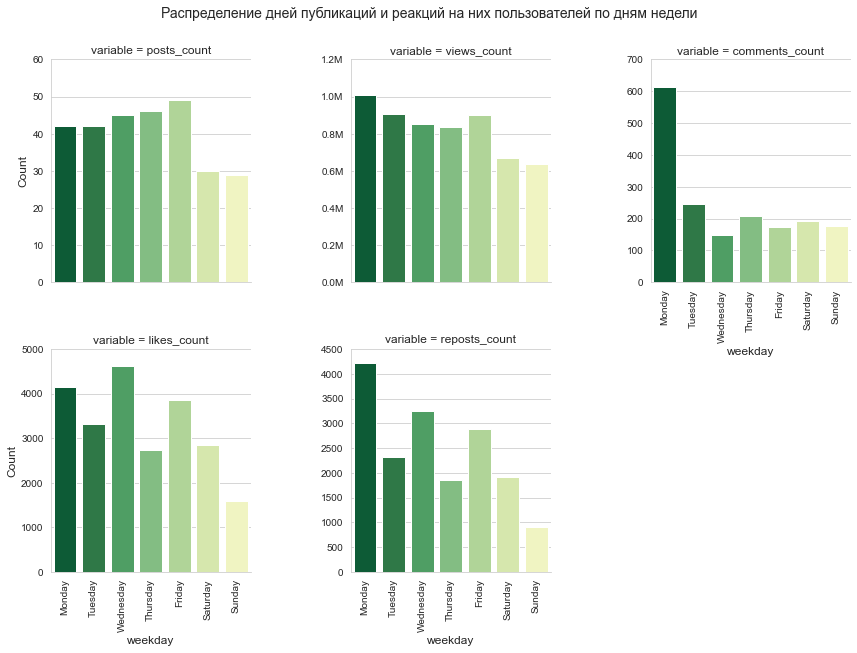

In [24]:
# построим сетку графиков
g=sns.catplot(data=data2,
              x='weekday',
              y= 'value',
              col='variable',
              col_wrap=3,
              kind='bar',
              ci=False,
              dodge=True,
              sharex=True,
              sharey=False,
              palette="YlGn_r",
              height=4,
              aspect=1
                          )

g.set_titles(size=12)
g.set_xlabels(fontsize=12)
g.set_xticklabels(rotation=90, fontsize=10)
g.set_ylabels('Count', fontsize=12)
g.set_yticklabels(fontsize=10)

# изменим подписи шкалы Y, определим их в миллионах для 2-го графика только
# а) исправляем User Warning: FixedFormatter should only be used together with FixedLocator заново устанавливае yticks
ticks_loc = g.axes[1].yaxis.get_ticklocs().tolist()
g.axes[1].set_yticks(ticks_loc)
# б) устанавливаем формат и значения
ylabels = [f"{(y / 1000000):.1f}M" for y in ticks_loc]
g.axes[1].set_yticklabels(ylabels, fontsize=10)
# Изменим  расстояния между графиками
plt.subplots_adjust(wspace=0.5, hspace=0.3)

plt.suptitle("Распределение дней публикаций и реакций на них пользователей по дням недели", fontsize=14, x=0.5, y=1.05)
plt.show()


**ВЫВОД**  
1. Наибольшее количество публикаций приходится на будние дни, причём их количество возрастает к пятнице. В субботу и воскресенье (когда у пользователей больше времени читать-!) публикаций значительно меньше. 
2. Максимальное количество просмотров, напротив приходится на публикации, созданные в понедельник, и падает к четвергу, слегка увеличиваясь для пятничных публикаций. Просмотров субботних и воскресных публикаций также существенно меньше (но и публикаций меньше - нечего просматривать)
3. Неожиданно: максимальное количество комментариев приходится на публикации, созданные в понедельник, значительно меньше - для вторничных публикаций. Дальнейшие колебания незначительны.
4. "Лайки" и репосты - здесь сложно выявить зависимость в колебаниях, однако минимумы приходятся на публикации от четвергов, суббот и воскресений.


#### 2.1.1.3. Распределение публикаций и реакций на них пользователей по часам публикации ####

In [25]:
# Cоздажим DF для работы с графиками в данном пункте
# Произведём сортировку и агрегацию по часам публикации
df_113 = df_work.groupby(["hours"], as_index=False)\
.agg({'text':['count'], 'views_count':['sum'], 'comments_count':['sum'], 'likes_count':['sum'], 'reposts_count':['sum']})
# Уберём мультиндекс в столбцах
df_113 = df_113.droplevel(level=1, axis=1)
# Переименуем столбцы по смыслу
df_113 = df_113.rename(columns={'text':'posts_count'})
# Остортируем записи по порядоквому номеру дня недели
df_113.sort_values("hours", inplace=True)
#df_113

In [26]:
# для построения графиков уберём поле с номерами дней недели и развернём таблицу в long-data формат
data3 = df_113.melt(id_vars="hours")
#data3

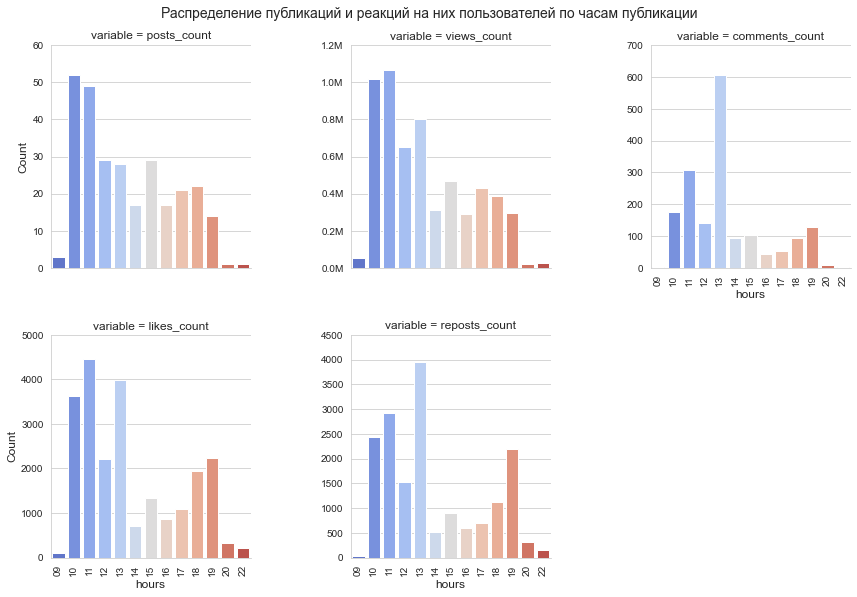

In [27]:
# построим сетку графиков
g=sns.catplot(data=data3,
              x='hours',
              y= 'value',
              col='variable',
              col_wrap=3,
              kind='bar',
              ci=False,
              dodge=True,
              sharex=True,
              sharey=False,
              palette="coolwarm",
              height=4,
              aspect=1
                          )

g.set_titles(size=12)
g.set_xlabels(fontsize=12)
g.set_xticklabels(rotation=90, fontsize=10)
g.set_ylabels('Count', fontsize=12)
g.set_yticklabels(fontsize=10)

# изменим подписи шкалы Y, определим их в миллионах для 2-го графика только
# а) исправляем User Warning: FixedFormatter should only be used together with FixedLocator заново устанавливае yticks
ticks_loc = g.axes[1].yaxis.get_ticklocs().tolist()
g.axes[1].set_yticks(ticks_loc)
# б) устанавливаем формат и значения
ylabels = [f"{(y / 1000000):.1f}M" for y in ticks_loc]
g.axes[1].set_yticklabels(ylabels, fontsize=10)
# Изменим  расстояния между графиками
plt.subplots_adjust(wspace=0.5, hspace=0.3)

plt.suptitle("Распределение публикаций и реакций на них пользователей по часам публикации", fontsize=14, x=0.5, y=1.025)
plt.show()


**ВЫВОД**  
1. Наибольшее количество публикаций создаётся в 10-11 часов утра. Наименьшее - в 9 утра и 20-22 часа. Количество публикаций, приходящихся на 11, 12 и 14 часов, приблизительно одинаковое. Есть спад в 13 часов (обеденное время) и в 16 часов (возможно из-за трудового распорядка соответствующих сотрудников Skillbox). 17-19 часов - минимальные значения в течение рабочего дня.
2. Картина просмотров, в целом, совпадает с графиком публикаций, с небольшим отличием в 11 часов утра, когда просмотры публикаций, размещённых в это время, составляет максимум за день. Просмотры также увеличиваются для публикаций, созданных в 13 часов.
3. Общая форма для графиков реакций пользователей отличается подобием. Характерен рост реакций для публикаций, размещённых в 11 часов. Заметен значительный рост комментариев и репостов для публикаций от 13 часов. Характерны сокращение реакций пользователей для послеобеденных публикаций и их рост для публикаций конца рабочего дня: 17-19 часов.


Выше рассмотрены абсолютные характеристики публикаций Skillbox на стене в VK. Абсолютные значения не показывают всю картину. Очень интересно изучить *относительные величины*: соотношения различных реакций пользователей к количеству просмотров публикаций. Их рассмотрим далее.

### 2.1.2. Временное распределение относительных величин для реакций пользователей ###

####  2.1.2.1. Хронология изменения реакций пользователей в отношении к числу просмотров  ####
>**ПРИМЕЧАНИЕ**  
>1. Это будут средние величины, получим их из предварительно агрегированных по датам публикаций абсолютных величин (df_111).
>2. Поскольку величины очень малы, далее они будут представлены в промилле.


In [28]:
# добавим к df_111 относительные велчины реакций пользователей в расчёте на один просмотр
df_111 = df_111.assign(comments_per_view=df_111.comments_count/df_111.views_count,
                          likes_per_view=df_111.likes_count/df_111.views_count,
                          reposts_per_view=df_111.reposts_count/df_111.views_count)
# добавим аналогичные стоблцы в df_work (понадобятся в другом разделе)
df_work = df_work.assign(comments_per_view=df_work.comments_count/df_work.views_count,
                          likes_per_view=df_work.likes_count/df_work.views_count,
                          reposts_per_view=df_work.reposts_count/df_work.views_count)
df_111.head(3)

,dates,posts_count,views_count,comments_count,likes_count,reposts_count,comments_per_view,likes_per_view,reposts_per_view
0,2021-10-01,3,44835,4,369,324,0.000089,0.008230,0.007226
1,2021-10-02,1,22668,6,312,250,0.000265,0.013764,0.011029
2,2021-10-03,1,24759,16,50,35,0.000646,0.002019,0.001414


**Важное замечание для построения временных графиков**: мы получили средние значения из агрегированного по датам DF, следовательно, они тоже агрегированы

In [29]:
df_work.sample(2)

,post_id,dates,hours,weekday,weekday_num,text,views_count,comments_count,likes_count,reposts_count,comments_per_view,likes_per_view,reposts_per_view
30,241979,2022-04-13,17,Wednesday,3,"Не секрет, что в декрете мамам приходится очен...",13272,2,23,8,0.000151,0.001733,0.000603
207,219591,2021-11-15,14,Monday,1,На этой неделе нас ждет сразу целых три марафо...,20324,6,26,35,0.000295,0.001279,0.001722


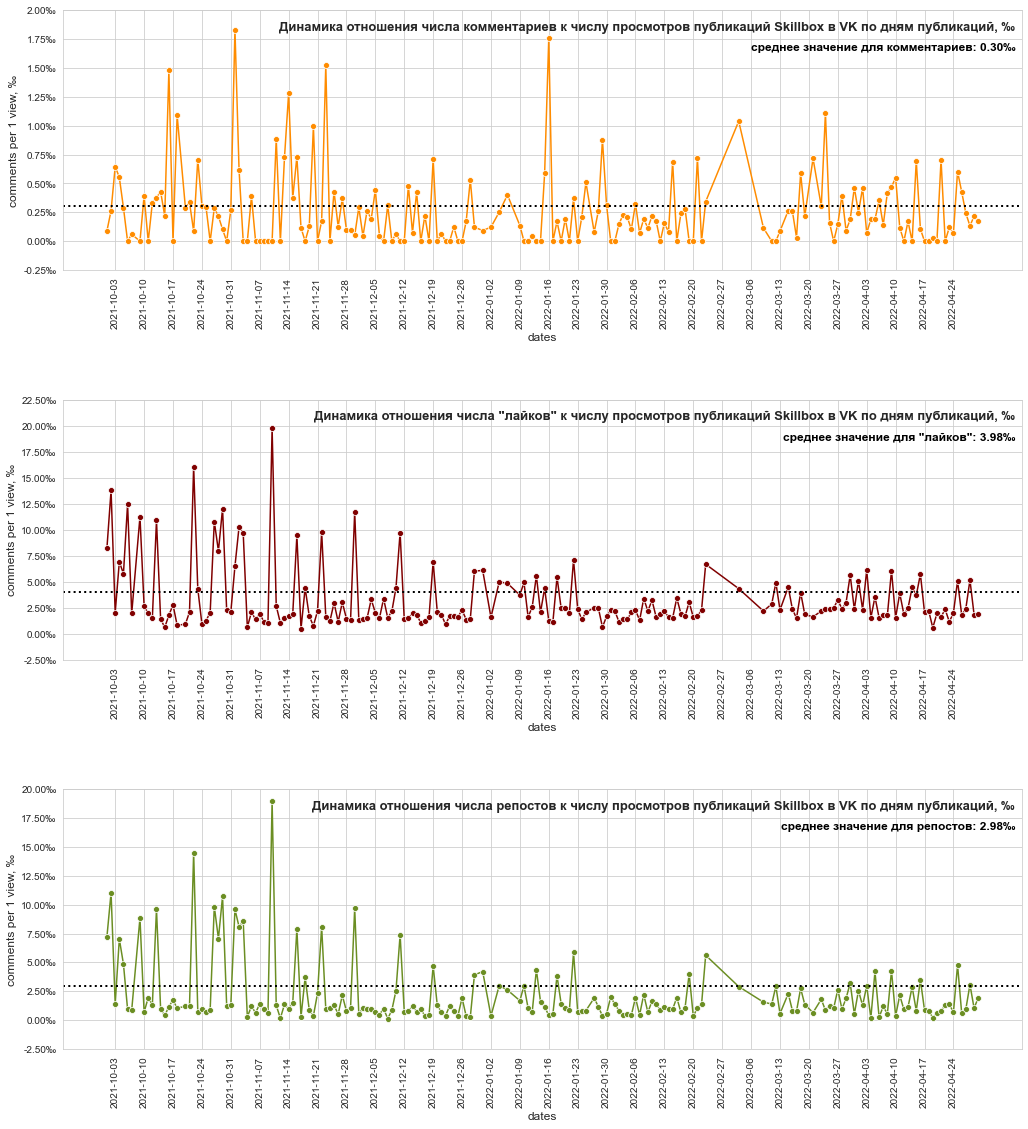

In [30]:
# Построим 3 графика сразу в цикле
# Создадим список параметров

param_list=[('comments_per_view', 'darkorange', 'комментариев', "comments_count"),
            ('likes_per_view', 'maroon', "\"лайков\"", "likes_count"), 
            ('reposts_per_view', 'olivedrab', "репостов", "reposts_count")]

fig, ax = plt.subplots(figsize=(14, 15), ncols=1, nrows=3)
# Определим расстояния между графиками
fig.tight_layout(h_pad=11)

for i, param in enumerate(param_list):
    sns.lineplot(data=df_111,
                 x='dates',
                 y=param[0],
                 #height=4,
                 #aspect=3.2,
                 marker='o',
                 color=param[1],
                 ax=ax[i]
                 )
    # Определяем шкалу X:
    # Определим шкалу как временной диапазон в формате Pandas с недельными интервалами (для читаемости):
    scale_span_x = pd.date_range(start=df_111.dates.min(),
                               end=df_111.dates.max(),
                               freq='W').tolist()
    ax[i].set_xticks(ticks=scale_span_x)  # установим шкалу X и размер её обозначений 
    ax[i].xaxis.set_tick_params(rotation=90, labelsize=10)

    # изменим подписи шкалы Y, определим их в промилле
    # а) исправляем User Warning: FixedFormatter should only be used together with FixedLocator заново устанавливае yticks
    ticks_loc = ax[i].get_yticks().tolist()
    ax[i].set_yticks(ticks_loc)
    # б) устанавливаем формат и значения
    ylabels = [f"{(y * 1000):.2f}‰" for y in ticks_loc]
    ax[i].set_yticklabels(ylabels, fontsize=10)

    # изменим подпись оси X 
    ax[i].set_xlabel("dates", fontsize=12)

    # изменим подпись оси Y
    ax[i].set_ylabel("comments per 1 view, ‰", fontsize=12)
    
    # Определим заголовок для каждого графика
    ax[i].set_title(
        f"Динамика отношения числа {param[2]} к числу просмотров публикаций Skillbox в VK по дням публикаций, ‰  ", 
                 fontsize=13, fontweight="bold", loc="right", y=0.9)

    # Добавим горизонтальные линии средней (количество действий пользователей на 1 просмотр по всей совокупности)
    mean_value=df_work[param[3]].sum()/df_work.views_count.sum()
    # Построение линии на основе принимаемых значений x, цвет, толщина, стиль
    ax[i].axhline(mean_value, color='black', linewidth=2, linestyle=':')
    # Создание подписи к линии 
    ax[i].annotate(
        text=f"среднее значение для {param[2]}: {(mean_value * 1000):.2f}‰  ", # Аннотация линии средней.
        xy=(1,0.875),  # Положение подписи линии (чтобы не перекрывать точки графика)
        xycoords="axes fraction",
        horizontalalignment='right',  # Выравнивание текста по горизонтали
        verticalalignment='top',  # Выравнивание текста по вертикали
        rotation=None, # Поворот подписи
        color='black', # Цвет надписи
        alpha=1,
        fontsize=12,
        fontweight="bold")

    
plt.show()


**ВЫВОД**  
***Комментарии***
1. Здесь уже нет строгой синхронности с количеством публикаций.
2. Основной промежуток колебания значений - от 0 до 0,75‰ (то есть 75 комментариев на 10'000 просмотров).
3. Максимальные соотношение комментариев к просмотрам характерно для публикаций:
- 16.10.2021 - 1,5‰ - причина не понятна;
- 18.10.2021 - около 1,15‰ - анонс бесплатных вебинаров;
- 01.11.2021 - около 1,85‰ - причины уже указаны выше: бесплатные курсы, закреплённое сообщение;
- 11.11.2021 - около 0,85‰ - возможная причина - интересная тема: противостояние травли в сети;
- 20.11.2021 - 1‰ - возможная причина - интересная тема Java;
- 23.11.2021 - более 1,5‰ - мероприятия в рамках "черной пятницы", интересная тема Warcraft;
- 16.01.2022 - около 1,75‰ - запись на психологический курс по эмоциям;
- 29.01.2022 - чуть выше 0,75‰ - возможная причина - интересная тема Java;
- 04.03.2022 - более 1‰ - интересная тема в сложных социально-экономических условиях, плюс бесплатный доступ к курсу "Как справиться с тревогой";
- 23.03.2022 - около 1,15‰ - актуальная тема в условиях блокировки зарубежных соцсетей: продвижение бизнеса в VK.  

***"Лайки" и репосты***  
1. Графики практически идентичны, отличия только в диапазоне значений. При этом графики совершенно не похожи на график отношения комментариев к просмотрам.
2. Колебания для "лайков", в основном, происходят в диапазоне от близкого к 0‰ до 7,5‰. Для репостов - от близкого к 0‰ до 6‰
3. Основные пиковые значения приходятся на 4-й квартал 2021 года до середины декабря, в 2022 высоких пиков пока не наблюдается:
- 02.10.2021 - сложно определить причину, возможно интересная тема;
- 06.10.2021 (только «лайки") - интересные темы: покер, инстаграм;
- 22.10.2021 - интересные темы: макияж, монтаж видео для соцсетей;
- 27.10.2021 - стразу 3 публикации, возможно, интересные темы;
- 28.10.2021 - сразу 4 публикации, возможно, интересные темы;
- 29.10.2021 - сразу 4 публикации, возможно, интересные темы;
- 01.11.2021 (только "репосты") - многократно рассмотрено выше: закреплённая тема, бесплатные курсы;
- 02.11.2021 - сертификаты на обучение, чёрная пятница, большие скидки;
- 03.11.2021 - интересная тема: личные инвестиции, а также программы лояльности;
- 10.11.2021 (максимум значений) - возможно, интересная тема для студентов;
- 16.11.2021 - интересная тема по психологии;
- 22.11.2021 - анонс бесплатных вебинаров;
- 30.11.2021 - возможно, интересная тема;
- 11.12.2021 - идеи подарков на Новый год.

Так же, как было показано ранее, видно постепенное снижение активности в течение 4-го квартала 2021 года, оживление в посленовогодний период, пауза в первые 10 дней с момента начала специальной военной операции, оживление с середины марта до настоящего времени, возможно, связанное с ослаблением ковидных ограничений. *Отдельно выделяется всплеск лайков относительно единичных публикаций во время паузы в конце февраля - начале марта 2022 года.*

#### 2.1.2.2. Распределение средних соотношений реакций пользователей к количеству просмотров по дням недели ####

In [31]:
# добавим к df_112 относительные велчины реакций пользователей в расчёте на один просмотр
df_112 = df_112.assign(comments_per_view=df_112.comments_count/df_112.views_count,
                          likes_per_view=df_112.likes_count/df_112.views_count,
                          reposts_per_view=df_112.reposts_count/df_112.views_count)
#df_112

In [32]:
# для построения графиков уберём поле с номерами дней недели и развернём таблицу в long-data формат
data2a = df_112.drop(
    ["weekday_num", "posts_count", "views_count", "comments_count", "likes_count", "reposts_count"],
    axis='columns').melt(id_vars="weekday")
#data2a

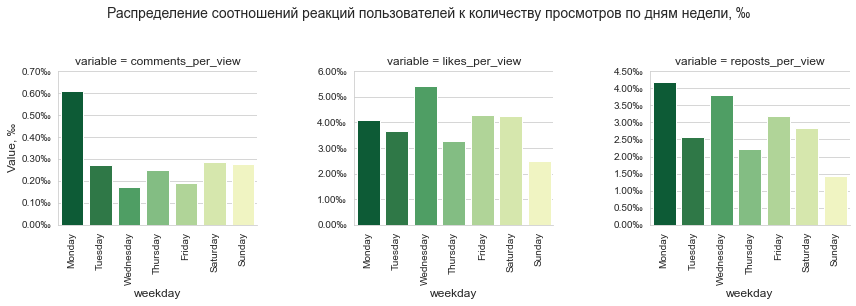

In [33]:
# построим сетку графиков

g=sns.catplot(data=data2a,
              x='weekday',
              y= 'value',
              col='variable',
             #col_wrap=4,
              kind='bar',
              ci=False,
              dodge=True,
              sharex=True,
              sharey=False,
              palette="YlGn_r",
              height=4,
              aspect=1
                          )
g.tight_layout()
plt.suptitle("Распределение соотношений реакций пользователей к количеству просмотров по дням недели, ‰", 
             fontsize=14, x=0.5, y=1.05)
# Установим параметры и размеры надписей: шкал, осей, заголовков графиков:
g.set_xticklabels(rotation=90, fontsize=10)
g.set_ylabels('Value, ‰', fontsize=12)
g.set_xlabels(size=12)
g.set_titles(size=12)
for i in range(0, 3):
    # изменим подписи шкалы Y, определим их в промилле
    # а) исправляем User Warning: FixedFormatter should only be used together with FixedLocator заново устанавливае yticks
    ticks_loc = g.axes[0][i].yaxis.get_ticklocs().tolist()
    g.axes[0][i].set_yticks(ticks_loc)
    # б) устанавливаем формат и значения
    ylabels = [f"{(y * 1000):.2f}‰" for y in ticks_loc]
    g.axes[0][i].set_yticklabels(ylabels, fontsize=10)

g.tight_layout(w_pad=6)
plt.show()


**ВЫВОД**  
Графики соотношения реакций к просмотрам практически дублирует графики количественных измерений реакций по дням недели публикаций. 

#### 2.1.2.3. Распределение средних соотношений реакций пользователей к количеству просмотров по часам публикаций ####

In [34]:
# добавим к df_113 относительные велчины реакций пользователей в расчёте на один просмотр
df_113 = df_113.assign(comments_per_view=df_113.comments_count/df_113.views_count,
                          likes_per_view=df_113.likes_count/df_113.views_count,
                          reposts_per_view=df_113.reposts_count/df_113.views_count)
#df_113


In [35]:
# для построения графиков уберём поле с номерами дней недели и развернём таблицу в long-data формат
data3a = df_113.drop(
    ["posts_count", "views_count", "comments_count", "likes_count", "reposts_count"],
    axis='columns').melt(id_vars="hours")
#data3a

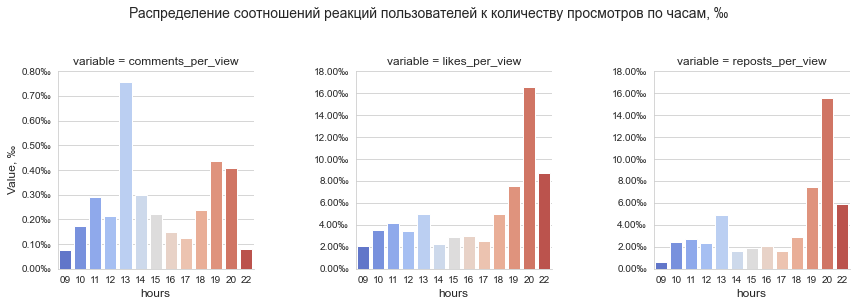

In [36]:
# построим сетку графиков

g=sns.catplot(data=data3a,
              x='hours',
              y= 'value',
              col='variable',
             #col_wrap=4,
              kind='bar',
              ci=False,
              dodge=True,
              sharex=True,
              sharey=False,
              palette="coolwarm",
              height=4,
              aspect=1
                          )
g.tight_layout()
plt.suptitle("Распределение соотношений реакций пользователей к количеству просмотров по часам, ‰", 
             fontsize=14, x=0.5, y=1.05)
# Установим параметры и размеры надписей: шкал, осей, заголовков графиков:
g.set_xticklabels(rotation=0, fontsize=10)
g.set_ylabels('Value, ‰', fontsize=12)
g.set_xlabels(size=12)
g.set_titles(size=12)
for i in range(0, 3):
    # изменим подписи шкалы Y, определим их в промилле
    # а) исправляем User Warning: FixedFormatter should only be used together with FixedLocator заново устанавливае yticks
    ticks_loc = g.axes[0][i].yaxis.get_ticklocs().tolist()
    g.axes[0][i].set_yticks(ticks_loc)
    # б) устанавливаем формат и значения
    ylabels = [f"{(y * 1000):.2f}‰" for y in ticks_loc]
    g.axes[0][i].set_yticklabels(ylabels, fontsize=10)

g.tight_layout(w_pad=6)
plt.show()


**ВЫВОД**  
1. Распределение отношений реакций пользователей к количеству просмотров по часам публикаций отличается от количественного распределения реакций пользователей.
2. Максимум комментариев к просмотрам приходится как раз на публикации, размещенные в обеденное время: 13 часов. Затем идут первые часы по окончании рабочего дня: 19-22 часа. Минимум соответствует 9 часам утра, средние значения - публикации, размещённые в первую половину рабочего дня и сразу после обеда.
3. "Лайки" показывают обратную картину по сравнению с графиком их абсолютных значений. Значительно выделяющийся максимум соответствует публикациям, размещённым в вечерние часы - 20 часов. Затем идет период 22 часов и 19 часов. Значения для рабочих часов значительно ниже максимумов и возрастают в течение первой половины дня к обеденному времени.
4. Картина для репостов, в общем-то, подобна "лайкам" с той лишь разницей, что соотношение репостов к просмотрам несколько ниже, чем "лайков" к просмотрам. Здесь на втором месте период 19 часов, затем 22 часов времени публикаций. Более существенно выделяется обеденное время 13 часов.


## 2.2. Содержательный анализ данных ##

### 2.2.1. Анализ тэгов ###

Выделим тэги публикаций. Добавим их в df_work

In [37]:
# Добавим в df_work столбец с тэгами публикаций. Не все публикации содержат тэги. Чтобы избежать ошибок,
# найдём тэги в отдельном списке текстов публикаций
posts_list = df_work.text.tolist() # создадим список текстов публикаций

tag_pattern = r"#\w+\b" # рег.выр. начинается с #, за которым следует 1 или более симоволов (образующих слова) до пробела 
reg_expr_compiled = re.compile(tag_pattern) # компиллируем регулярное выражение
post_tag_list = [] # список тэгов публикаций
for post in posts_list: # проходим по списку текстов публикаций
    tag = reg_expr_compiled.findall(post) # находим тэг (рузультат функции - список, содержащий тэг)
    if tag != []: # если тэг не является пустым списком (то есть, если тэг обнаружен)
        tag = tag[0] # присваиваем тэгу значение первого элемента этого списка
    else:
        tag = "undefined" # иначе, присваиваем тэгу значение "не определён"
    post_tag_list.append(tag) # добавляем результирующих тэг в список тэгов
       
df_work = df_work.assign(post_tag = post_tag_list) # добавляем полученный список в качестве отдлеьного столбца в DF
df_work.sample(5)

,post_id,dates,hours,weekday,weekday_num,text,views_count,comments_count,likes_count,reposts_count,comments_per_view,likes_per_view,reposts_per_view,post_tag
37,241467,2022-04-09,10,Saturday,6,А по стоимости сориентируете?\n\nЕсли вы фрила...,23431,11,142,100,0.000469,0.006060,0.004268,undefined
231,215120,2021-10-29,17,Friday,5,"Вы из тех, кто всегда обращает внимание на чуж...",20583,9,32,19,0.000437,0.001555,0.000923,undefined
168,225885,2021-12-13,13,Monday,1,"Знаете, что, помимо Нового года, очень скоро п...",19524,20,39,21,0.001024,0.001998,0.001076,#Skillbox_маркетинг
258,212949,2021-10-15,10,Friday,5,"У нас нет дела любимее, чем рассказывать об ус...",20788,0,16,5,0.000000,0.000770,0.000241,#Skillbox_мультимедиа
107,232882,2022-01-30,11,Sunday,7,"Порой кажется, что кардинально изменить свою ж...",19355,6,32,11,0.000310,0.001653,0.000568,undefined


#### 2.2.1.1. Распределение публикаций и их просмотров по тэгам ####

In [38]:
# Создадим DF для анализа и построения графиков в данном пункте (удалив строки с пустыми тэгами)
df_211 = df_work[["post_id", "views_count", "post_tag"]].sort_values(by="post_tag")
df_211.sample(3)

,post_id,views_count,post_tag
229,215197,18407,#Skillbox_программирование
216,216759,17740,undefined
65,236393,17211,undefined


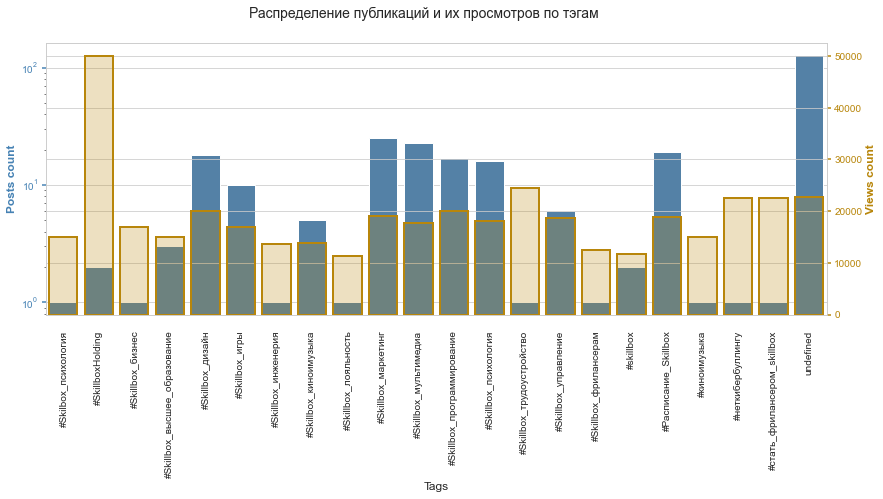

In [39]:
fig, ax = plt.subplots(figsize=(14, 5), ncols=1, nrows=1) # определим полотно графика
twin1 = ax.twinx() # определим второй график на той же оси X

sns.countplot(data=df_211, # график подсчёта количества публикаций по разным тэгам 
            x="post_tag",
            color='steelblue',
            ax=ax)

sns.barplot(data=df_211, # график зависимости количества просмотров от тэгов
            x="post_tag",
            y="views_count",
            ci=False,
            facecolor=(0.7216, 0.5255, 0.0431, .25), # darkgoldenrod, alpha=0.25
            linewidth=2,
            edgecolor='darkgoldenrod',
            ax=twin1)

plt.suptitle("Распределение публикаций и их просмотров по тэгам", fontsize=14)

# Параметры оси X
ax.set_xlabel('Tags', fontsize=12)
ax.tick_params(axis='x', labelrotation=90, size=12)

# параметры оси Y для основного и второго графиков
ax.set_ylabel('Posts count', fontsize=12, fontweight='bold', color='steelblue') 
twin1.set_ylabel('Views count', fontsize=12, fontweight='bold', color='darkgoldenrod')
ax.tick_params(axis='y', colors='steelblue', size=4, width=1.5)
twin1.tick_params(axis='y', colors='darkgoldenrod', size=4, width=1.5)
# Логарифмические шкалы осей Y
ax.set_yscale('log')
# twin1.set_yscale('log')

plt.show()


In [40]:
df_work[["dates", "text","post_tag"]][df_work.post_tag =='undefined'].dates.count()

128

**ВЫВОД**  
1. Максимальное количество публикаций не имеет тематического тэга - их более 120. Около 10-12 (почти в 10 раз меньше) публикаций приходятся на каждый из тэгов:
- Маркетинг,
- Мультимедиа,
- Расписание,
- Дизайн,
- Программирование,
- Психология,
- Игры.
Другие тэги соответствуют единичным публикациям.
2. Распределение количества просмотров принципиально иное. Максимум здесь приходится на SkillboxHolding - около 50 тыс. просмотров. Остальные тэги собирают в 2 более раз меньше просмотров. Основные из них:
- Трудоустройство (25 тыс.),
- Нет кибербуллингу, стать фрилансером, публикации без тэга (около 23 тыс.),
- Дизайн,
- Программирование,
- Маркетинг,
- Расписание,
- Управление,
- Психология,
- Мультимедиа.
На каждый из них приходится около 20 тыс. просмотров.
Другие Тэги набирают существенно ниже 20 тыс. просмотров.
3. Если судить о популярности тэгов по просмотрам, то получается, что количество публикаций по тэгам недостаточно учитывает их популярность. Более популярные тэги требуют большего количества публикаций. Недостаточным учётом популярности тэгов можно объяснить большое количество просмотров и реакций на них для, казалось бы, непримечательных публикаций.
4. Просмотр текстов без тэга, показывает, что на самом деле он легко классифицируются по имеющимся тэгам, но по неизвестной причине тэг в них отсутствует. Если посмотреть на даты таких публикаций, но никакой системности в пропуске тэгов не выявляется. Такая ситуация может быть связана: с программными ошибками, неаккуратностью при осуществлении публикации, какими-то упущениями или нарушениями регламента осуществления публикаций.

#### 2.2.1.2. Распределение рекаций пользователей относительно количества просмотров по тэгам. ####

In [41]:
# Создадим DF для анализа и построения графиков в данном пункте (удалив строки с пустыми тэгами)
df_212 = df_work[["views_count", "comments_count", "likes_count", "reposts_count", "post_tag"]]
df_212 = df_212.groupby(["post_tag"], as_index=False).agg('sum')
df_212 = df_212.assign(comments_per_view=df_212.comments_count/df_212.views_count,
                          likes_per_view=df_212.likes_count/df_212.views_count,
                          reposts_per_view=df_212.reposts_count/df_212.views_count)
df_212.sample(3)

,post_tag,views_count,comments_count,likes_count,reposts_count,comments_per_view,likes_per_view,reposts_per_view
20,#стать_фрилансером_skillbox,22601,6,101,52,0.000265,0.004469,0.002301
14,#Skillbox_управление,111920,81,228,135,0.000724,0.002037,0.001206
15,#Skillbox_фрилансерам,12436,0,45,28,0.000000,0.003619,0.002252


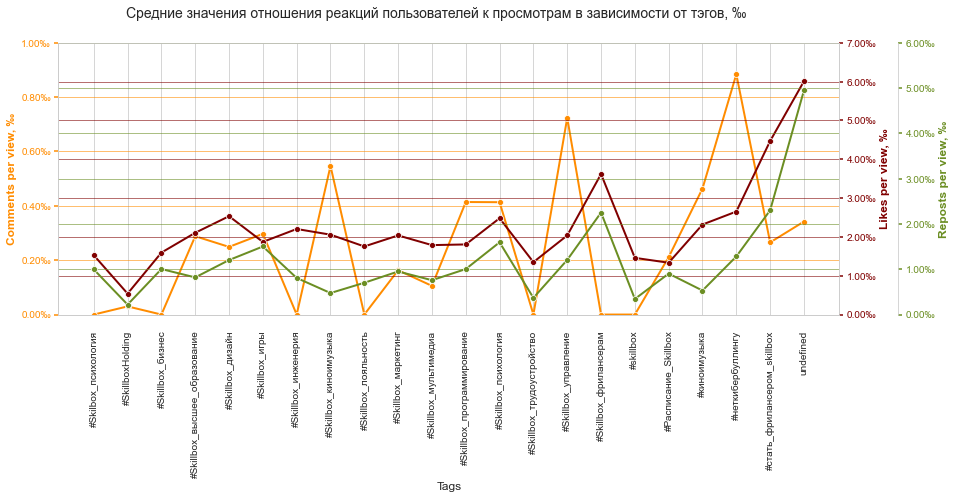

In [42]:
fig, ax = plt.subplots(figsize=(14, 5), ncols=1, nrows=1) # определим полотно графика
twin1 = ax.twinx() # определим второй график на той же оси X
twin2 = ax.twinx() # определим третий график на той же оси X
# Определим диапазоны шкал Y
ax.set_ylim(0, 0.001)
twin1.set_ylim(0, 0.007)
twin2.set_ylim(0, 0.006)

# сместим ось Y для twin2 вправо (ось уже распололжена справа методом twinx
twin2.spines.right.set_position(("axes", 1.075))

sns.lineplot(data=df_212, # график зависимости комментариев к просмотрам от тэга
            x="post_tag",
            y="comments_per_view",
            linewidth=2,
            color='darkorange',
            marker='o',
            ax=ax)

sns.lineplot(data=df_212, # график зависимости 'лайков' к просмотрам от тэга
            x="post_tag",
            y="likes_per_view",
            linewidth=2,
            color='maroon',
            marker='o',
            ax=twin1)

sns.lineplot(data=df_212, # график зависимости репостов к просмотрам от тэга
            x="post_tag",
            y="reposts_per_view",
            linewidth=2,
            color='olivedrab',
            marker='o',
            ax=twin2)

plt.suptitle("Средние значения отношения реакций пользователей к просмотрам в зависимости от тэгов, ‰", fontsize=14)

# Параметры оси X
ax.set_xlabel('Tags', fontsize=12)
ax.tick_params(axis='x', labelrotation=90, size=12)

# параметры оси Y для основного и дополнительных графиков
ax.set_ylabel('Сomments per view, ‰', fontsize=12, fontweight='bold', color='darkorange') 
twin1.set_ylabel('Likes per view, ‰', fontsize=12, fontweight='bold', color='maroon')
twin2.set_ylabel('Reposts per view, ‰', fontsize=12, fontweight='bold', color='olivedrab')
ax.tick_params(axis='y', colors='darkorange', size=4, width=1.5, 
               grid_color='darkorange', grid_alpha=0.75, grid_linewidth=0.75, grid_linestyle="-")
twin1.tick_params(axis='y', colors='maroon', size=4, width=1.5, 
               grid_color='maroon', grid_alpha=0.75, grid_linewidth=0.75, grid_linestyle="-")
twin2.tick_params(axis='y', colors='olivedrab', size=4, width=1.5, 
               grid_color='olivedrab', grid_alpha=0.75, grid_linewidth=0.75, grid_linestyle="-")
# изменим подписи шкал Y, определим их в промилле
# а) исправляем User Warning: FixedFormatter should only be used together with FixedLocator заново устанавливае yticks
ticks_loc = ax.yaxis.get_ticklocs().tolist()
ax.set_yticks(ticks_loc)
# б) устанавливаем формат и значения
ylabels = [f"{(y * 1000):.2f}‰" for y in ticks_loc]
ax.set_yticklabels(ylabels, fontsize=10)

ticks_loc = twin1.yaxis.get_ticklocs().tolist()
twin1.set_yticks(ticks_loc)
ylabels = [f"{(y * 1000):.2f}‰" for y in ticks_loc]
twin1.set_yticklabels(ylabels, fontsize=10)

ticks_loc = twin2.yaxis.get_ticklocs().tolist()
twin2.set_yticks(ticks_loc)
ylabels = [f"{(y * 1000):.2f}‰" for y in ticks_loc]
twin2.set_yticklabels(ylabels, fontsize=10)

plt.show()


**ВЫВОД**  
1. Наибольшее соотношение комментариев к просмотрам соответствует тэгу "Нет кибербуллингу". На втором месте - "Управление", затем - "Кино и музыка". На четвертом месте находятся "Психология и "Программирование", на пятом - "Игры" и "Высшее образование.
2. Соотношения "лайков" к просмотрам и репостов к просмотрам ведут себя похоже друг другу, но совершенно отлично от комментариев. На первом месте: публикации без тэга. На втором - "Стать филантропом". На третьем - "Фрилансерам". Далее "лайки" и репосты ведут себя по-разному. "Лайки": четвёртое место "Нет кибербуллингу", пятое - "Дизайн" и "Психология". Репосты: четвёртое место "Игры" и "Психология", пятое - "Дизайн" и "Нет кибербуллингу".

### 2.2.2. Анализ лексики публикаций ###

#### 2.2.2.1 Частотные характеристики употребления слов ####

Определим перечень наиболее употребляемых слов во всём массиве изучаемых постов Skillbox в VK.

In [43]:
# ОБРАБОТКА ТЕКСТОВ ИЗ DF ДЛЯ СОЗДЕНИЯ СПИСКА НОРМАЛИЗОВАННЫХ ЗНАЧИМЫХ СЛОВ

# Глобальные определения:
# Вызов метода .MorphAnalyzer() библиотеки pymorphy2:
morph = pymorphy2.MorphAnalyzer() 
# Шаблон регулярного выражения для вычленения отдельных слов:
reg_expr = r'\w+'
# компилляция регулярного выражения для вычленения отдельных слов:
reg_expr_compiled = re.compile(reg_expr)
# Шаблон регулярного выражения для удаления гиперссылок:
no_http_reg_expr = r'http[s]?://\S+'
# Список исходных текстов из DF
init_texts_list = []
# Список текстов из приведенных к исходной форме слов,
# кроме служебных частей речи и именных местоимений (список нормализованных значимых частей речи):
norm_сlean_texts_list = []

# Функция для определения частей речи 
def pos(word):
    # возрвращаем вероятную часть речи для аргумента word
    return morph.parse(word)[0].tag.POS

# Функция разбиения текста в список слов, приведённых к нижнему регистру и за исключегием служебных частей речи 
# (междометия, частицы, союзы, предлоги), а также личных местоимений
def norm_clean_low_words_maker(text=""):
    # Приводим исходный текст к нижнему регистру 
    try: # (обработка ошибок, если в тексте попадётся NaN)
        lowered_text = text.lower()
    except:
        print('error is here!', text)
    # Удалаем из текста все гиперссылки:
    no_http_text = re.sub(no_http_reg_expr, '', lowered_text, flags=re.MULTILINE)
    # Разбиваем текст на слова:
    # применяем метод findall для поиска всех совпадений с шаблоном регулярного выражения в тексте, 
    words_list = reg_expr_compiled.findall(no_http_text)
    # Исключаем из текста междометия, частицы, союзы, предлоги, именные местоимения: 
    # грамемы русского языка: для исключения 
     # междометия, частицы, союзы, предлоги, личные местоимения
    functors_pos = {'INTJ', 'PRCL', 'CONJ', 'PREP', 'NPRO'}
    # проверяем и нормализуем слова
    norm_clean_low_words_list=[] # список нормализованных слов в нижнем регистре кроме служебных частей речи
    for word in words_list:
        # если результат вызова функции не является служебной частью речи или именным местоимением
        if pos(word) not in functors_pos:
            # приводим слово к исходной форме (normalized)
            parsed_word = morph.parse(word) # результат вызова morph - список из разных элементов
            normalized_word = parsed_word[0].normal_form # выбираем исходную форму слова из результата вызова morph
            # добавляем исходную форму проверенного слова в список исходных форм
            norm_clean_low_words_list.append(normalized_word) # добавляем проверенное слово в список
    return norm_clean_low_words_list
    
# форимируем исходный список текстов из df_work 
init_texts_list = df_work.text.tolist()

# Получим список текстов из нормализованных значимых частей речи за счёт 
# применения функции norm_clean_low_words_maker к каждому элементу (тексту) в начальном списке текстов init_texts_list
try: # (обработка ошибок, если в тексте попадётся NaN)
    norm_сlean_texts_list = list(map(norm_clean_low_words_maker, init_texts_list))
except:
    print('error')
# результат
# print (norm_сlean_texts_list)

In [44]:
# Содадим DF с ID публикаций и соответствующими им нормализованными словами
# Создадим список ID публикаций из того же df_work (cоответствующий init_texts_list и norm_сlean_texts_list)
init_texts_index = df_work.post_id.tolist()

# Для создания DF из списка кортежей, определим такой список
list_of_tuples = []
for i, text_ in enumerate(norm_сlean_texts_list): # для каждого i и текста в списке нормализованных значимых слов
    for word_ in text_: # для каждого слово в таком тексте
        # соединим в кортеже ID публикации и слово, добавим кортеж в список 
        list_of_tuples.append(tuple([init_texts_index[i], word_])) 

# Создадим DF на основе списка кортежей, обозначим названия столбцов        
df_norm_words = pd.DataFrame(list_of_tuples, columns=['post_id', 'words'])

# имправим частную ошибку мфть -> мфти
df_norm_words.loc[df_norm_words.words == 'мфть', ["words"]] = 'мфти'
df_norm_words

,post_id,words
0,215343,нет
1,215343,шутка
2,215343,попробовать
3,215343,34
4,215343,курс
...,...,...
14674,209879,ходить
14675,209879,детство
14676,209879,музыкальный
14677,209879,школа


In [45]:
# Создадим DF с подсчётом встречаемости нормализованных слов (по убыванию) среди всех публикаций Skillbox в VK:
# - группируем по словам,
# - агрегируем с подсчётом количества публикаций для каждодго слова,
# переименовываем post_id по смыслу: "частота встречаемости слова",
# - сортируем частоты по убыванию:
df_norm_words_occurrence = df_norm_words.groupby(["words"], as_index=False)\
.agg('count')\
.rename(columns={"post_id":"word_occurrence_freq"})\
.sort_values(by="word_occurrence_freq", ascending=False) 

df_norm_words_occurrence

,words,word_occurrence_freq
1421,курс,194
1727,наш,173
1254,карточка,163
2908,свой,155
1380,который,154
...,...,...
1561,метафора,1
1562,меташкола,1
1563,метеорит,1
1565,метрика,1


In [46]:
# Создадим DF с разбивкой по публикациям и указанием втречаемости каждого слова из публикации в общем массиве слов
# - объединим DFs с ID публикаций и встречаемостью слов по полю "слова"
# - отсортируем по ID публикаций и встречаемости слов в убывающем порядке
df_norm_words_occurrence_by_post = df_norm_words.merge(df_norm_words_occurrence, on="words", how='left')\
.sort_values(by=["post_id","word_occurrence_freq"], ascending=False) 
df_norm_words_occurrence_by_post

,post_id,words,word_occurrence_freq
41,244472,который,154
77,244472,который,154
42,244472,хотеть,137
60,244472,этот,103
76,244472,тот,92
...,...,...,...
14650,209879,обида,1
14652,209879,вводить,1
14655,209879,нотный,1
14656,209879,стан,1


In [47]:
## Альтернативный вариант с функцией подсчёта встречаемости слов - на порядок медленнее:
#df_norm_words_occurrence_by_post1 = df_norm_words
#df_norm_words_occurrence_by_post1 = df_norm_words_occurrence_by_post1.assign(word_weigh = df_norm_words_occurrence_by_post1.words.apply(
#    lambda x: df_norm_words_occurrence_by_post1.words[df_norm_words_occurrence_by_post1.words == x].count()))
#
#df_norm_words_occurrence_by_post1 = df_norm_words_occurrence_by_post1.sort_values(by=["post_id","word_weigh"],ascending=False)
#df_norm_words_occurrence_by_post1


Исходя из подготовленных выше данных, рассмотрим частотные характеристики использованных в публикациях слов и их влияние на реакции пользователей.


##### 2.2.2.1.A. Расперделение слов по частотным характеристикам #####

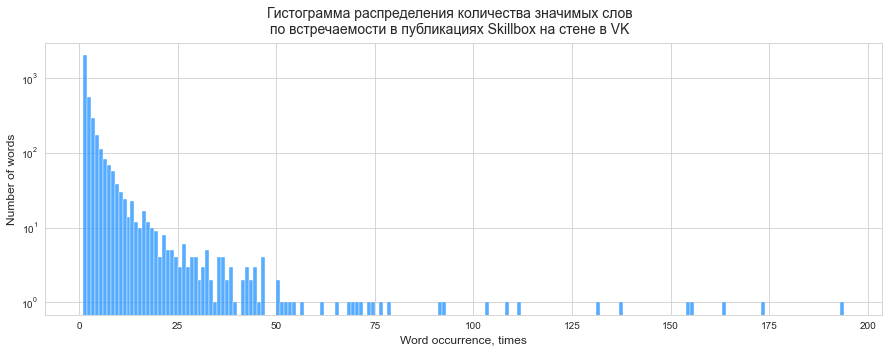

In [48]:
# Построим гистограмму распределения количества значимых слов по встречаемости в публикациях
fig, ax = plt.subplots(figsize=(15,5), ncols=1, nrows=1)
sns.histplot(data=df_norm_words_occurrence,
            x="word_occurrence_freq",
            binwidth=1,
            color='dodgerblue',
            ax=ax)
ax.set_yscale('log')
ax.set_xlabel('Word occurrence, times', fontsize=12)
ax.set_ylabel('Number of words', fontsize = 12)
plt.suptitle(f"Гистограмма распределения количества значимых слов\n"\
             f"по встречаемости в публикациях Skillbox на стене в VK",
            fontsize=14)
plt.show()

In [49]:
volcabulary = df_norm_words_occurrence.words.count()
frequent_words = df_norm_words_occurrence.word_occurrence_freq[df_norm_words_occurrence.word_occurrence_freq >= 20].count()
most_freq_words = df_norm_words_occurrence\
.word_occurrence_freq[df_norm_words_occurrence.word_occurrence_freq > 20].count()

print("Объем словаря значимых слов: ", volcabulary, "\n20 и более раз используется: ", frequent_words,
     "\nМенее 20 раз используется: ", volcabulary-frequent_words,
     "\nБолее 20 раз используется: ", most_freq_words)

Объем словаря значимых слов:  3717 
20 и более раз используется:  117 
Менее 20 раз используется:  3600 
Более 20 раз используется:  113


**ВЫВОД**  
1. Общий словарь значимых слов, использованный при составлении публикаций, составляет 3717 слова. Это не очень много с точки зрения лексического многообразия русского языка.
2. Подавляющее число значимых слов (более 1000) встречается публикациях не более одного раза. 3600 слов используется не более 20 раз. Но есть слова, используемые слишком часто от 21 до 192 раз. На это следует обратить внимание. Таких слов 113. Некоторые из них встречаются внутри одного и того же сообщения не по одному разу.


Для определения, в какой мере та или иная публикация использует часто встречаемые слова, введём усреднённый показатель: средняя встречаемость слов в публикации. Для его получения сумму встречаемостей каждого значимого слова разделим на количество значимых слов в публикации.

##### 2.2.2.1.B. Характеристика публикаций по встречаемости используемых слов #####

In [50]:
# Создадим отедльный DF для данного подраздела.
# Для этог группируем df_norm_words_occurrence_by_post по номерам публикаций, подсчитываем в них значимые слова и
# вычисляем сумму встречаемости слов.
df_221b=df_norm_words_occurrence_by_post.groupby(["post_id"], as_index=False)\
.agg({"words":'count', "word_occurrence_freq":'sum'})
# Добавляем новый столбец для средней встречаемости слов в публикации
df_221b["avg_word_occurrence"] = df_221b.word_occurrence_freq / df_221b.words
# Переименовываем столбцы по смыслу
df_221b.rename(columns={"words":"words_count", "word_occurrence_freq":"total_word_occurrence"}, inplace=True)
# Добавим данные о средней встречаемости слов в публикации в df_work
df_work = df_work.merge(df_221b, on="post_id", how='left')
df_221b.sample(3)

,post_id,words_count,total_word_occurrence,avg_word_occurrence
185,233254,66,2501,37.893939
248,241586,38,1399,36.815789
110,224981,60,2017,33.616667


In [51]:
df_work.sample(1)

,post_id,dates,hours,weekday,weekday_num,text,views_count,comments_count,likes_count,reposts_count,comments_per_view,likes_per_view,reposts_per_view,post_tag,words_count,total_word_occurrence,avg_word_occurrence
42,241065,2022-04-05,14,Tuesday,2,Главное в дизайне — насмотренность. Именно бла...,15882,3,56,67,0.000189,0.003526,0.004219,#Skillbox_дизайн,41,930,22.682927


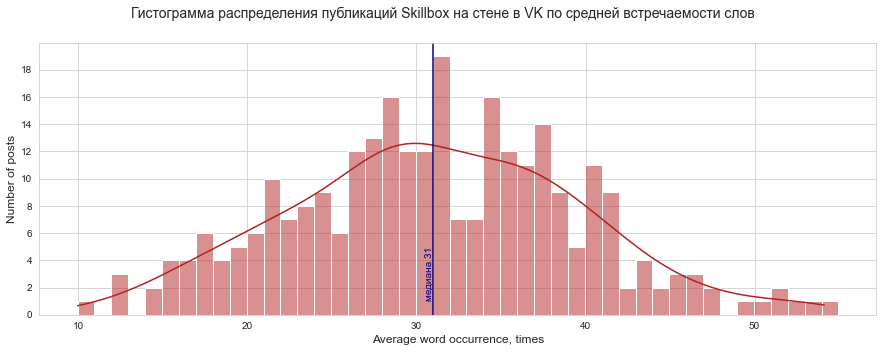

In [52]:
# Построим гистограмму распределения публикаций по средней встречаемости слов
fig, ax = plt.subplots(figsize=(15,5), ncols=1, nrows=1)
sns.histplot(data=df_221b,
            x="avg_word_occurrence",
            binwidth=1,
            kde=True,
            color='firebrick',
            ax=ax)

ax.set_yticks(ticks=range(0,19,2))
#ax.set_yscale('log')
ax.set_xlabel('Average word occurrence, times', fontsize=12)
ax.set_ylabel('Number of posts', fontsize = 12)

# Прочертим линию медианы
median_value = df_221b.avg_word_occurrence.median()
ax.axvline(x=median_value, color="navy")
# Создание подписи 
ax.annotate(               
    text=f"медиана {median_value:.0f}",
    xy=(median_value-0.2, 1),  # Положение подписи (чтобы не перекрывать точки графика)
    xycoords='data',
    horizontalalignment='center',  # Выравнивание текста по горизонтали
    verticalalignment='bottom',  # Выравнивание текста по вертикали
    rotation=90, # Поворот подписи
    color='navy', # Цвет надписи
    alpha=1,
    fontsize=10,
    fontweight="normal")

plt.suptitle('Гистограмма распределения публикаций Skillbox на стене в VK по средней встречаемости слов ',
            fontsize=14)
plt.show()

**ВЫВОД**  
1. Распределение носит близкий к стандартному характер.
2. Средняя встречаемость значимых слов в публикации варьирует от 10 до 54, с медианой в 31 раз. Это значит, что половина публикаций имеет среднюю встречаемость слов на уровне более 31 раза. Это очень высокий показатель.
3. Большое количество публикаций с высокой средней встречаемостью слов говорит о том, что при их подготовке не было уделено внимание словесному многообразию, мало использовались синонимы. Скорее всего, такие публикации готовились формально, по шаблону, тексты в них стандартизованы и упрощены в ущерб красноречию.

##### 2.2.2.1.C. Распределение средней встречаемости слов по датам публикаций #####


In [53]:
# Создадим новый DF, выбрав данные о средней встречаемости слов в публикациях и датах публикаций из df_work
df_221c = df_work[["post_id", "avg_word_occurrence", "dates"]]
df_221c.sample(3)

,post_id,avg_word_occurrence,dates
224,215686,21.277778,2021-11-02
211,217727,21.580247,2021-11-11
238,214835,12.352941,2021-10-27


**Важное замечание для построения временных графиков**: df_221с, в отличие от DF, исользованных для временных графиков выше, неагрегирован. Для построения графика его необходимо агрегировать по датам. При этом необходимо будет *усреднить относительные величины* (соотношение показателя встречаемости каждого значимого слова к сумме значимых слов в публикации). Поэтому, для усреднения в рамках даты показателя встречаемости слов в публикации, необходимо использовать среднюю гармоническую величину. 

In [54]:
df_221c=df_221c.groupby("dates", as_index=False).agg({"post_id":'count', "avg_word_occurrence":stats.hmean})
df_221c.head(3)

,dates,post_id,avg_word_occurrence
0,2021-10-01,3,28.255351
1,2021-10-02,1,34.238095
2,2021-10-03,1,31.108696


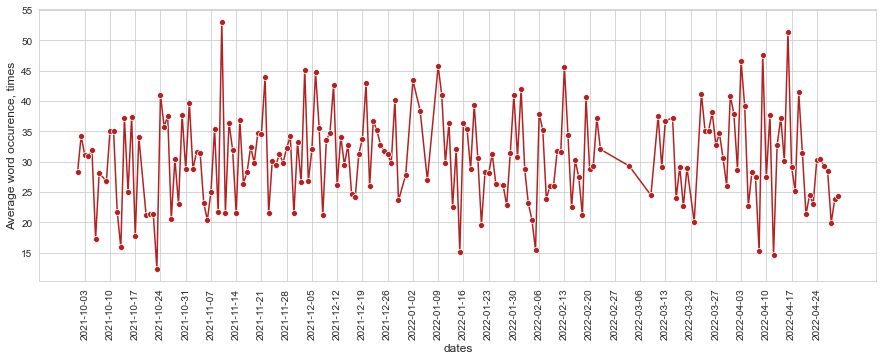

In [55]:
fig, ax = plt.subplots(figsize=(15, 5), ncols=1, nrows=1)

sns.lineplot(data=df_221c,
             x='dates',
             y="avg_word_occurrence",
             marker='o',
             color='firebrick',
             ci=False,
             ax=ax
             )
# Определяем шкалу X:
# Определим шкалу как временной диапазон в формате Pandas с недельными интервалами (для читаемости):
scale_span_x = pd.date_range(start=df_221c.dates.min(),
                           end=df_221c.dates.max(),
                           freq='W').tolist()
ax.set_xticks(ticks=scale_span_x)  # установим шкалу X и размер её обозначений 
ax.xaxis.set_tick_params(rotation=90, labelsize=10)

# изменим подпись оси X 
ax.set_xlabel("dates", fontsize=12)

# изменим подпись оси Y
ax.set_ylabel("Average word occurence, times", fontsize=12)
ax.yaxis.set_tick_params(labelsize=10) # установим размер её обозначений шкалы Y

plt.show()


**ВЫВОД**  
1. Временное распределение публикаций по средней встречаемости слов не показывает сколько-нибудь значимых тенденций. 
2. Есть отдельные примеры.  

К худшим с точки зрения средней встречаемости слов (крайне высокая) можно отнести публикации:
- 10.11.2021 - продуктивность учёбы и приложения для её повышения - тэг не определён;
- 16.04.2022 - портфолио для фрилансера - тэг не определён;
- 09.04.2022 - стоимость работы для фрилансера - тэг не определён;
- 03.04.2022 - процесс обучения в Skillbox.  
  
К лучшим (низкая средняя встречаемость) можно отнести:
- 23.10.2021 - винтажная колода игральных карт - #Skillbox_дизайн;
- 12.04.2022 - интересные вакансии - тэг не определён;
- 15.01.2022 - дизайн для экокосметики - #Skillbox_дизайн.


##### 2.2.2.1.D. Распределение средней встречаемости значимых слов в публикациях по дням недели ##### 

In [56]:
# создадим DF с нужными данными из df_work
df_221d = df_work[["post_id", "weekday", "weekday_num", "words_count", "total_word_occurrence"]]
df_221d = df_221d.groupby(["weekday", "weekday_num"], as_index=False).agg({"post_id":'count', 
                                                                "words_count":'sum',
                                                                "total_word_occurrence":'sum'})
df_221d["avg_word_occurrence"] = df_221d.total_word_occurrence / df_221d.words_count 
df_221d = df_221d.sort_values(by=["weekday_num"]).drop("weekday_num", axis='columns')
df_221d = df_221d.rename(columns={"post_id":"post_count", "words_count":"total_word_count"})
df_221d

,weekday,post_count,total_word_count,total_word_occurrence,avg_word_occurrence
1,Monday,42,1659,58553,35.294153
5,Tuesday,42,2360,70832,30.013559
6,Wednesday,45,2419,70841,29.285242
4,Thursday,46,2653,74835,28.207689
0,Friday,49,2668,77393,29.007871
2,Saturday,30,1547,45640,29.502262
3,Sunday,29,1373,44321,32.280408


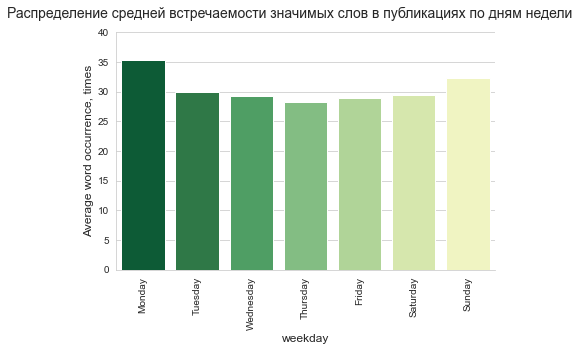

In [57]:
# Построим график распределения средней встречаемости значимых слов в публикациях по дням недели
data = df_221d[["weekday", "avg_word_occurrence"]]
# построим сетку графиков
g=sns.catplot(data=data,
              x='weekday',
              y= 'avg_word_occurrence',
              kind='bar',
              ci=False,
              dodge=True,
              palette="YlGn_r",
              height=4,
              aspect=1.5
                          )

g.set_titles(size=12)
g.set_xlabels(fontsize=12)
g.set_xticklabels(rotation=90, fontsize=10)
g.set_ylabels('Average word occurrence, times', fontsize=12)
g.set_yticklabels(fontsize=10)

plt.suptitle("Распределение средней встречаемости значимых слов в публикациях по дням недели", 
             fontsize=14, y=1.05)
plt.show()


**ВЫВОД**  
1. Распределение публикаций по средней встречаемости значимых слов по дням недели не отличается разнообразием. 
2. В относительно небольшом диапазоне можно сделать вывод, что лучшими с точки зрения низкой встречаемости значимых слов, являются публикации, размещённые в среду. Худшими - в субботу и особенно в воскресенье. Возможно, именно в эти дне характерен более формальный нежели творческий подход к составлению текстов.

##### 2.2.2.1.E. Взаимозависимости средней встречаемости значимых слов в публикации и реакций пользователей относительно числа просмотров ##### 

In [58]:
# Создадим новый DF, выбрав данные из df_work
df_221e = df_work[["comments_per_view", "likes_per_view", "reposts_per_view", "avg_word_occurrence"]]
df_221e.sample(3)

,comments_per_view,likes_per_view,reposts_per_view,avg_word_occurrence
55,0.000000,0.001545,0.000803,37.568182
28,0.000695,0.003666,0.000822,30.134146
209,0.000726,0.001453,0.001362,31.972973


In [59]:
# Создадим новый DF, выбрав данные из df_work
df_221e = df_work[["comments_per_view", "likes_per_view", "reposts_per_view", "avg_word_occurrence"]]
df_221e.sample(3)

,comments_per_view,likes_per_view,reposts_per_view,avg_word_occurrence
95,0.000193,0.003370,0.002215,23.866667
173,0.000000,0.002136,0.000865,33.616667
243,0.000307,0.000922,0.000974,41.026316


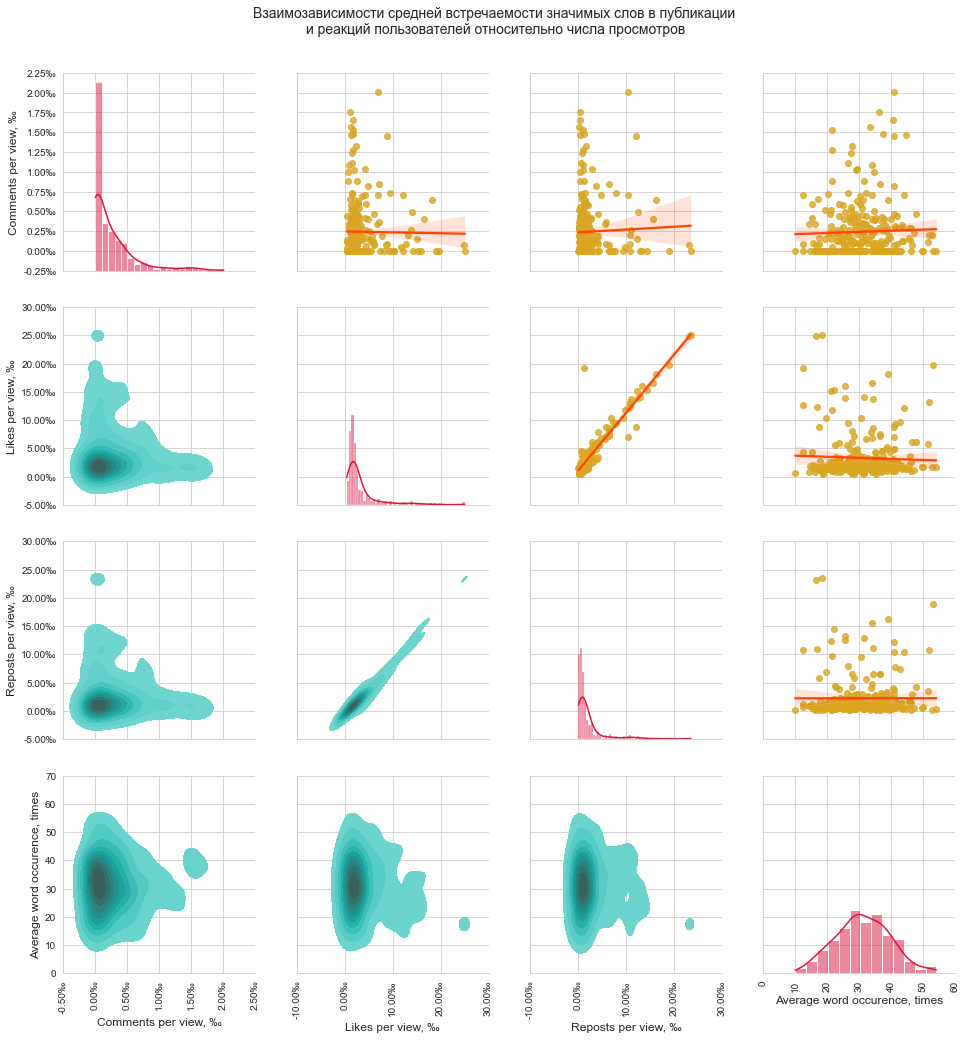

In [60]:
# построим paigrid для анализа попарной зависимости параметров

g = sns.PairGrid(data=df_221e,
                height=3.5,
                aspect=1,
                layout_pad=2.75)
g.map_upper(sns.regplot, color='goldenrod', line_kws=dict(color='orangered'))
g.map_lower(sns.kdeplot, color='lightseagreen', fill=True)
g.map_diag(sns.histplot, kde=True, color='crimson')

plt.suptitle(f"Взаимозависимости средней встречаемости значимых слов в публикации \n"
             f"и реакций пользователей относительно числа просмотров", y=1.025, fontsize=14)

# изменим параметры осей и шкал X и Y
label_list=["Comments per view, ‰", "Likes per view, ‰", "Reposts per view, ‰", "Average word occurence, times"]

for i, axes_label in enumerate(label_list):
    # а) исправляем User Warning: FixedFormatter should only be used together with FixedLocator заново устанавливае yticks
    ticks_loc_y = g.axes[i][0].get_yticks().tolist()
    ticks_loc_x = g.axes[3][i].get_xticks().tolist()
    g.axes[i][0].set_yticks(ticks_loc_y)
    g.axes[3][i].set_xticks(ticks_loc_x)
    # б) устанавливаем формат и значения
    if i < 3: # последний график измеряется в разах, а не промилле
        y_t_labels = [f"{(y * 1000):.2f}‰" for y in ticks_loc_y]
        x_t_labels = [f"{(x * 1000):.2f}‰" for x in ticks_loc_x]
    else:
        y_t_labels = [f"{(y * 1):.0f}" for y in ticks_loc_y]
        x_t_labels = [f"{(x * 1):.0f}" for x in ticks_loc_x]
    g.axes[i][0].set_yticklabels(y_t_labels, fontsize=10)
    g.axes[i][0].set_ylabel(axes_label, fontsize=12)
    g.axes[3][i].set_xticklabels(x_t_labels, fontsize=10, rotation=90)
    g.axes[3][i].set_xlabel(axes_label, fontsize=12)

plt.show()


**ВЫВОД**  
1. Комментарии в отношении к просмотрам:
- часть комментариев имеет низкий показатель отношения к просмотрам, подавляющая часть - крайне близкий к 0;
- взаимозависимости со значением "лайков" к просмотрам не выявляется;
- взаимозависимость со значением "репостов" имеет маловыраженный положительный характер (увеличение репостов в отношении к просмотрам при росте комментариев к просмотрам.
- взаимозависимость со средней встречаемостью слов положительная, но еще менее выраженная.
2. "Лайки" к просмотрам:
- основная доля сосредоточена в зоне менее 5‰ при максимуме около 25‰;
- выявляется чёткая положительная взаимозависимость с отношением репостов к просмотрам (это подтверждает выводы, сделанные ранее);
- выявляется *отрицательная зависимость по отношению к средней встречаемости слов в публикациях*: чем больше средняя встречаемость, тем меньше отметок, что публикация понравилась в отношении к просмотрам; такое явление вряд ли носит осознанный характер, но, скорее всего, пользователи интуитивно предпочитают более красноречивые сообщения.
3. Репосты к просмотрам:
- еще более концентрированы у нулевых показателей: при максимуме около 23‰ основная доля сосредоточена в зоне до 3‰;
- зависимости от средней встречаемости слов в публикациях не выявляется.


#### 2.2.2.2. Смысловая окрашенность слов ####

Существует целый ряд слов, которые носят позитивную или негативную смысловую окраску. При соответствующих знаниях в области прикладной психологии (например, neuro-linguistic programming - NLP\*, применительно к коммуникации), которые позволят грамотно использовать такие слова , можно составлять достаточно сильные мотивирующие или демотивирующие тексты.
Интересно будет изучить, в какой мере слова с различной смысловой окраской используются в публикациях Skillbox на стене в VK.
>**ПРИМЕЧАНИЕ**
Словари негативных и позитивных слов, которые удалось найти автору, разилчаются по своему объёму: словарь позитивных слов намного шире, словаря негативных слов. Поэтому определение степени негативности текстов может быть искажёно в сторону улучшения результата.

* \*) За более подробной информацией можете обращаться к автору этого исследования.*


Изучим состав публикаций с точки зрения позитивных (положительных, мотивирующих) слов. Для этого загрузим достаточно большой перечень таких слов, найденный в Интернете на сайте *Positive Words Research* https://positivewordsresearch.com/positive-words-russian/

In [61]:
# Функция чтения текста по URL адерсу (использует библиотеку bs4 BeautifulSoup)
def get_text(url): 
    rs = requests.get(url)
    root = BeautifulSoup(rs.content, 'html.parser')
    article = root.select_one('article')
    return article.text

url = "https://positivewordsresearch.com/positive-words-russian/"
positive_words_text = get_text(url)
#print(positive_words_text)

Полученный текст необходимо очистить от вступления, заключения и повторяющихся вставок-алфавитных разделителей, а также нормализовать.
>**ПРИМЕЧАНИЕ**  
Приведенный ниже код не универсальный, а создан именно для данного текста


In [62]:
# регулярные выражения для удаления частей текста.
reg_expr_list = [r'\n+', # 1 и более символов перевода строки
                 r'(.*)(?=абсолютно)', # любые символы, кроме перевода строки, до слова "абсолютно"
                 r'(?<=ясный)(.*)', # любые символы, кроме перевода строки, после слова "ясный"
                 r'положительные слова, которые начинаются с .?', # любой символ (одно повторение после "начинаются с ")
                 r'положительные слова, которые начинаются .?'] #любой символ (одно повтроение после "начинаются ")
                 # вычленить слова
                 
for reg_expr in reg_expr_list:
    positive_words_text = re.sub(reg_expr, ' ', positive_words_text) # выполняем замену найденных строк на пробелы
#print(positive_words_text)

# Вычленим слова, очистим от служебных частей речи, нормализуем (аналогично функции norm_clean_low_words_maker)
reg_expr = r'\w+' # вычленить слова
# компилляция регулярного выражения для вычленения отдельных слов
reg_expr_compiled = re.compile(reg_expr)
positive_words_list = reg_expr_compiled.findall(positive_words_text)
# нормализуем список:
# грамемы русского языка: для исключения 
# междометия, частицы, союзы, предлоги, личные местоимения
functors_pos = {'INTJ', 'PRCL', 'CONJ', 'PREP', 'NPRO'}
# проверяем и нормализуем слова
norm_clean_positive_words_list=[] # список нормализованных слов в нижнем регистре кроме служебных частей речи
for word in positive_words_list:
    # если результат вызова функции не является служебной частью речи или именным местоимением
    if pos(word) not in functors_pos:
        # приводим слово к исходной форме (normalized)
        parsed_word = morph.parse(word) # результат вызова morph - список из разных элементов
        normalized_word = parsed_word[0].normal_form # выбираем исходную форму слова из результата вызова morph
        # добавляем исходную форму проверенного слова в список исходных форм
        norm_clean_positive_words_list.append(normalized_word) # добавляем проверенное слово в список

#print(norm_clean_positive_words_list)


Сопоставим каждое слово в df_norm_words_count_by_post и df_norm_words_occurrence со списком нормализованных позитивных слов norm_clean_positive_words_list.

In [63]:
df_norm_words_occurrence_by_post = \
df_norm_words_occurrence_by_post.assign(positive=
                            df_norm_words_occurrence_by_post.words.apply(lambda x: x in norm_clean_positive_words_list))
df_norm_words_occurrence = \
df_norm_words_occurrence.assign(positive=
                            df_norm_words_occurrence.words.apply(lambda x: x in norm_clean_positive_words_list))


In [64]:
df_norm_words_occurrence_by_post[df_norm_words_occurrence_by_post.positive == True].sample(3)

,post_id,words,word_occurrence_freq,positive
4321,234131,один,43,True
13805,211069,полезный,26,True
9732,221965,жизнь,46,True


In [65]:
df_norm_words_occurrence[df_norm_words_occurrence.positive == True].sample(3)

,words,word_occurrence_freq,positive
2234,поддержка,3,True
1628,мощный,1,True
2447,практический,3,True


Выясним, какие из встречаемых слов в публикациях Skillbox в VK носят негативный (отрицательный, демотивирующий) характер. Для этого загрузим перечень таких слов, найденный в Интернете на сайте *wordsonline.ru* https://wordsonline.ru/samples/negative.html
>**ПРИМЕЧАНИЕ**  
>1. Список слов сохранён в файл MS Excel.
>2. Слова уже нормализованы.

In [66]:
# Создадим список негативных слолв, прочитав его из файла Excel
negative_word_list = pd.read_excel("negative_words.xlsx", header=0, index_col=0, usecols=[0,1]).word.tolist()
#negative_word_list

Сопоставим каждое слово в df_norm_words_occurrence_by_post и в df_norm_words_occurrence со списком нормализованных негативных слов negative_word_list.

In [67]:
df_norm_words_occurrence_by_post = \
df_norm_words_occurrence_by_post.assign(negative=
                                  df_norm_words_occurrence_by_post.words.apply(lambda x: x in negative_word_list))
df_norm_words_occurrence = \
df_norm_words_occurrence.assign(negative=
                                  df_norm_words_occurrence.words.apply(lambda x: x in negative_word_list))


In [68]:
df_norm_words_occurrence_by_post[df_norm_words_occurrence_by_post.negative == True].sample(3)


,post_id,words,word_occurrence_freq,positive,negative
6249,231563,рутина,1,False,True
14405,210224,ущерб,1,False,True
10889,217727,насилие,1,False,True


In [69]:
df_norm_words_occurrence[df_norm_words_occurrence.negative == True].sample(3)

,words,word_occurrence_freq,positive,negative
1771,ненависть,1,False,True
3332,тревога,5,False,True
1862,обида,1,False,True


##### 2.2.2.2.A. Расперделение позитивных и негативных слов по частотным характеристикам #####

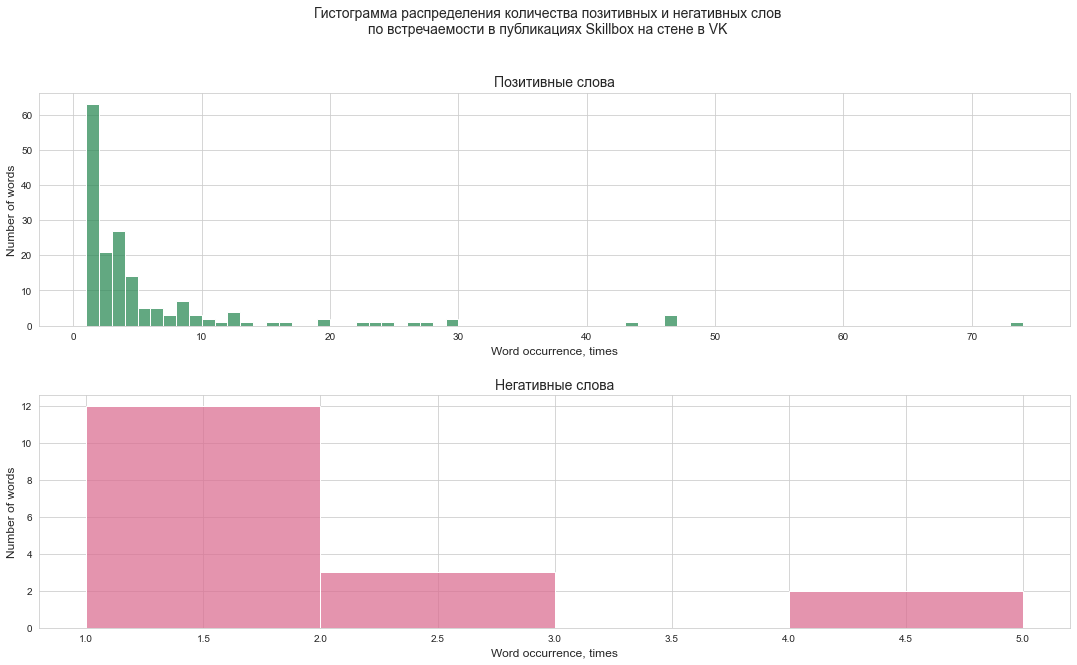

In [70]:
# Построим гистограмму распределения количества позитивных и негативных слов по встречаемости в публикациях
fig, ax = plt.subplots(figsize=(15,8), ncols=1, nrows=2)
fig.tight_layout(h_pad=5)
data1 = df_norm_words_occurrence[df_norm_words_occurrence.positive==True]
data2 = df_norm_words_occurrence[df_norm_words_occurrence.negative==True]
param_list=[[data1, 'seagreen', "Позитивные слова"], [data2,'palevioletred', "Негативные слова"]]

for i, param in enumerate(param_list):
    sns.histplot(data=param[0],
                x="word_occurrence_freq",
                binwidth=1,
                color=param[1],
                ax=ax[i])

    ax[i].set_xlabel('Word occurrence, times', fontsize=12)
    ax[i].set_ylabel('Number of words', fontsize = 12)
    ax[i].set_title(f"{param[2]}", fontsize = 14)


plt.suptitle(f"Гистограмма распределения количества позитивных и негативных слов\n"
             f"по встречаемости в публикациях Skillbox на стене в VK",
            fontsize=14, y=1.125)
plt.show()


In [71]:
vocabulary = df_norm_words_occurrence.words.count()
positive_voc = df_norm_words_occurrence.positive.sum()
negative_voc = df_norm_words_occurrence.negative.sum() 
print(f"Общее количество позитивных слов в словарном запасе: {positive_voc}, то есть {(positive_voc/vocabulary*100):.2f}%")
print(f"Общее количество негативных слов в словарном запасе: {negative_voc}, то есть {(negative_voc/vocabulary*100):.2f}%")

Общее количество позитивных слов в словарном запасе: 172, то есть 4.63%
Общее количество негативных слов в словарном запасе: 17, то есть 0.46%


**ВЫВОД**  
1. Общее количество позитивных слов, используемых в публикациях, равно 172, что составляет 4,63% от общего запаса значимых слов. Несмотря на то, что общий максимум встречаемости позитивных слов находится на уровне свыше 70, большинство позитивных слов имеет встречаемость до 10 раз и менее. Свыше 10 раз встречаются единицы позитивных слов. Это *очень низкие показатели*. Можно предположить, что позитивности письменной речи, системному употреблению отрицаний и суггестивности уделяется недостаточно внимания.
2. Количество употребляемых негативных слов невелико. Их всего 17 - менее 0,5%. Большинство негативных слов (12) встречается по одному разу. Избегание негативной смысловой окраски - это хороший признак.


Проанализируем соотношение позитивных и негативных слов к общему числу слов в каждой отдельной публикации. В отличие от средней встречаемости слов в публикации, которая показывала, насколько та или иная публикация использует часто встречаемые слова, здесь мы выясним общую степень "позитивности" и "негативности" каждой публикаций.

##### 2.2.2.2.B. Характеристика публикаций по степени позитивности и негативности #####


In [72]:
# Создадим отедльный DF для данного подраздела.
# Для этого:

# - в новом DF группируем df_norm_words_occurrence_by_post по номерам публикаций, 
# - подсчитываем в них значимые позитивные и негативные слова и
# - вычисляем отношения количества позитивных и негативных слов к общему числу слов в публикации.
df_222b=df_norm_words_occurrence_by_post.drop(columns="word_occurrence_freq")
df_222b=df_norm_words_occurrence_by_post.groupby(["post_id"])\
.agg({"words":'count', "positive":'sum', "negative":'sum'})

# Добавляем новые столбцы для доли позитивных и негативных слов в общем количестве слов в публикации
df_222b["pos_fraction"] = df_222b.positive / df_222b.words
df_222b["neg_fraction"] = df_222b.negative / df_222b.words

# Переименовываем столбцы по смыслу
df_222b.rename(columns={"words":"words_count", "word_occurrence_freq":"total_word_occurrence",
                       "positive":"pos_word_count", "negative":"neg_word_count"}, inplace=True)
df_222b.sample(5)


,words_count,pos_word_count,neg_word_count,pos_fraction,neg_fraction
post_id,,,,,
210364,40,0,1,0.000000,0.025
233426,46,2,0,0.043478,0.000
215356,31,1,0,0.032258,0.000
212361,61,5,0,0.081967,0.000
212949,95,9,0,0.094737,0.000


In [73]:
# Добавим данные о доле позитивных и негативных слов в публикации в df_work
df_work = df_work.merge(df_222b[["pos_fraction", "neg_fraction" ]], on="post_id", how='left')
df_work.sample(1)


,post_id,dates,hours,weekday,weekday_num,text,views_count,comments_count,likes_count,reposts_count,comments_per_view,likes_per_view,reposts_per_view,post_tag,words_count,total_word_occurrence,avg_word_occurrence,pos_fraction,neg_fraction
243,214301,2021-10-24,10,Sunday,7,"Давно мечтаете открыть свое дело, но никак не ...",19515,6,18,19,0.000307,0.000922,0.000974,#Skillbox_управление,38,1559,41.026316,0.026316,0.0


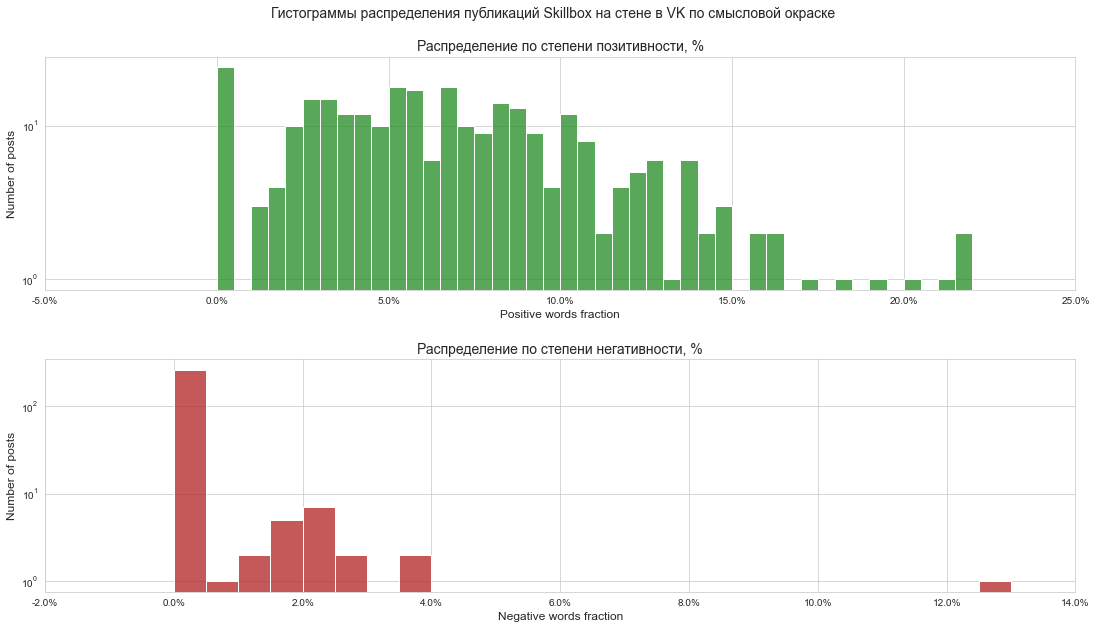

In [74]:
fig, ax = plt.subplots(figsize=(15,8), ncols=1, nrows=2)
fig.tight_layout(h_pad=5)
data = df_222b
param_list=[["pos_fraction", 'forestgreen', "позитивности", "Positive"], 
            ["neg_fraction",'firebrick', "негативности", "Negative"]]

for i, param in enumerate(param_list):
    sns.histplot(data=df_222b,
                x=param[0],
                binwidth=0.005,
                color=param[1],
                ax=ax[i])

    ax[i].set_xlabel(f"{param[3]} words fraction", fontsize=12)
    ax[i].set_ylabel('Number of posts', fontsize = 12)
    ax[i].set_title(f"Распределение по степени {param[2]}, %", fontsize = 14)
    # изменим подписи шкалы Y, определим их в процнтах
    # а) исправляем User Warning: FixedFormatter should only be used together with FixedLocator заново устанавливае yticks
    ticks_loc = ax[i].get_xticks().tolist()
    ax[i].set_xticks(ticks_loc)
    # б) устанавливаем формат и значения
    xlabels = [f"{(y * 100):.1f}%" for y in ticks_loc]
    ax[i].set_xticklabels(xlabels, fontsize=10)
    ax[i].set_yscale('log')
plt.suptitle(f"Гистограммы распределения публикаций Skillbox на стене в VK по смысловой окраске",
            fontsize=14, y=1.0625)
plt.show()


In [75]:
texts_num=df_work.post_id.count()
texts_pos = df_222b.pos_fraction[df_222b.pos_fraction != 0].count()
texts_neg = df_222b.neg_fraction[df_222b.neg_fraction != 0].count()
print(f"Общее количество публикаций {texts_num} \n"
      f"Общее количество публикаций, содержащих позитивные слова {texts_pos} то есть {(texts_pos/texts_num*100):.1f}%\n", 
      f"Общее количество публикаций, содержащих негативные слова {texts_neg} то есть {(texts_neg/texts_num*100):.1f}%", )

Общее количество публикаций 283 
Общее количество публикаций, содержащих позитивные слова 259 то есть 91.5%
 Общее количество публикаций, содержащих негативные слова 20 то есть 7.1%


**ВЫВОД**  
1. Публикации, содержащие позитивные слова, составляют более 91% всего массива изучаемых текстов. Средняя степень позитивности публикаций колеблется от 0 до 24%. При этом большая доля публикаций имеет степень позитивности на уровне до 1%. Основная часть публикаций имеет степень позитивности, не превышающую 10%. В диапазоне от 10% до 15% степень позитивности заметно снижается. В диапазоне от 15% до 24% степени позитивности находятся единичные публикации. Конечно, *желательно было бы повысить число публикаций с высокой степенью использования позитивных слов*.
2. Публикации, содержащие негативные слова составляют 7,1% всех публикаций. Средняя степень негативности публикаций колеблется от 0 до 13%. Более 200 публикаций имеют степень негативности от 0 до 1%. Основное количество негативных публикаций сосредоточено в диапазоне негативности от 1 до 2,5%. Есть 1 публикация со степенью негативности 13%. В целом, это хорошие показатели.


##### 2.2.2.2.C. Распределение степени позитивности и негативности по датам публикаций #####


In [76]:
# Создадим новый DF, выбрав данные о средней встречаемости слов в публикациях и датах публикаций из df_work
df_222c = df_work[["post_id", "dates", "pos_fraction", "neg_fraction"]]
df_222c.sort_values(by="dates").head(3)

,post_id,dates,pos_fraction,neg_fraction
282,209879,2021-10-01,0.034483,0.017241
281,209989,2021-10-01,0.054054,0.000000
280,210012,2021-10-01,0.047619,0.000000


**Важное замечание для построения временных графиков**: df_222с, в отличие от DF, исользованных для временных графиков выше, неагрегирован. Для построения графика его необходимо агрегировать по датам. При этом необходимо будет *усреднить относительные величины* (доля позитивных и доля негативные слов в общем количестве слов в публикации). Поэтому, для усреднения в рамках даты, необходимо использовать среднюю гармоническую величину.

In [77]:
df_222c=df_222c.groupby("dates", as_index=False).agg({"post_id":'count', 
                                                      "pos_fraction":stats.hmean, 
                                                      "neg_fraction":stats.hmean})
df_222c.head(3)

,dates,post_id,pos_fraction,neg_fraction
0,2021-10-01,3,0.043796,0.0
1,2021-10-02,1,0.023810,0.0
2,2021-10-03,1,0.043478,0.0


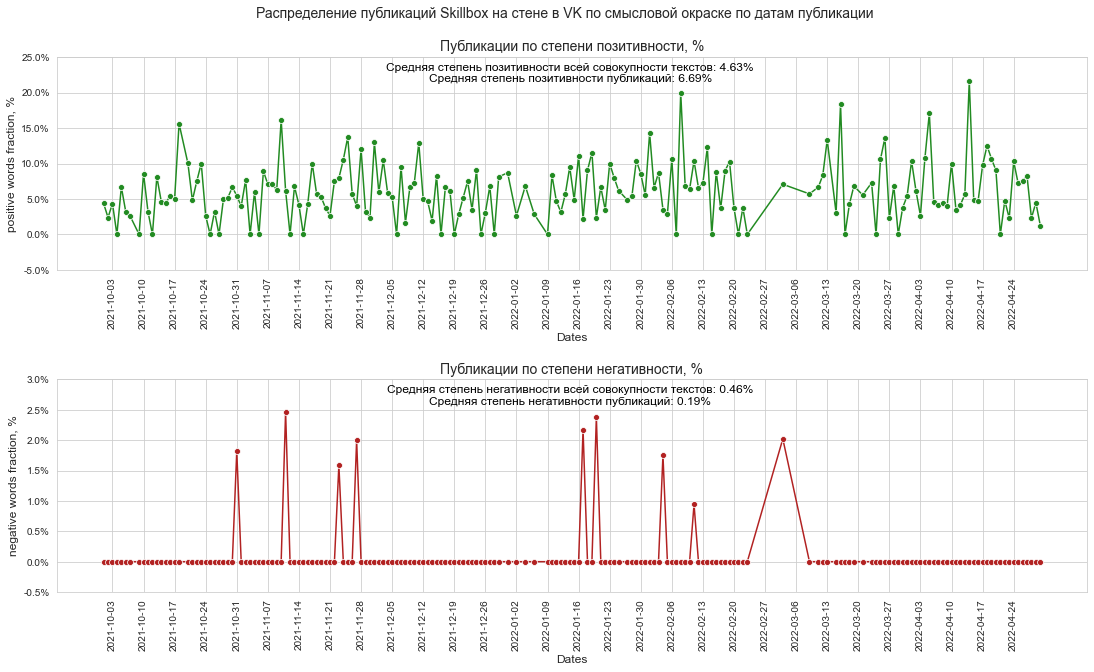

In [78]:
fig, ax = plt.subplots(figsize=(15,8), ncols=1, nrows=2)
fig.tight_layout(h_pad=9)
data = df_222b
param_list=[["pos_fraction", 'forestgreen', "позитивности", "positive"], 
            ["neg_fraction",'firebrick', "негативности", "negative"]]

# Определим шкалу как временной диапазон в формате Pandas с недельными интервалами (для читаемости):
scale_span_x = pd.date_range(start=df_222c.dates.min(),
                           end=df_222c.dates.max(),
                           freq='W').tolist()

for i, param in enumerate(param_list):
    sns.lineplot(data=df_222c,
                 x='dates',
                 y=param[0],
                 marker='o',
                 color=param[1],
                 ci=False,
                 ax=ax[i]
                 )
    # Определяем шкалу X:
    ax[i].set_xticks(ticks=scale_span_x)  # установим шкалу X и размер её обозначений 
    ax[i].xaxis.set_tick_params(rotation=90, labelsize=10)

    ax[i].set_xlabel("Dates", fontsize=12)
    ax[i].set_ylabel(f"{param[3]} words fraction, %", fontsize=12)
    ax[i].set_title(f"Публикации по степени {param[2]}, %", fontsize = 14)
    # изменим подписи шкалы Y, определим их в процнтах
    # а) исправляем User Warning: FixedFormatter should only be used together with FixedLocator заново устанавливае yticks
    ticks_loc = ax[i].get_yticks().tolist()
    ax[i].set_yticks(ticks_loc)
    # б) устанавливаем формат и значения
    ylabels = [f"{(y * 100):.1f}%" for y in ticks_loc]
    ax[i].set_yticklabels(ylabels, fontsize=10)
#    ax[i].set_yscale('log')

    # Вычисление значений средней степени позитивности/негативности
    mean_value_total=df_norm_words_occurrence[param[3]].sum() / df_norm_words_occurrence.words.count() * 100
    mean_value=data[param[0]].mean()*100
    # Создание подписи к средней величине
    ax[i].annotate(
        text=(f"Средняя степень {param[2]} всей совокупности текстов: {mean_value_total:.2f}% \n"
              f"Средняя степень {param[2]} публикаций: {mean_value:.2f}% "),
        xy=(0.5,0.975),  # Положение подписи (чтобы не перекрывать точки графика)
        xycoords="axes fraction",
        horizontalalignment='center',  # Выравнивание текста по горизонтали
        verticalalignment='top',  # Выравнивание текста по вертикали
        rotation=None, # Поворот подписи
        color='black', # Цвет надписи
        alpha=1,
        fontsize=12,
        fontweight="light")
plt.suptitle(f"Распределение публикаций Skillbox на стене в VK по смысловой окраске по датам публикации",
            fontsize=14, y=1.0625)
plt.show()


# STOPPED #

In [79]:
print(f"Маскисмальная доля негативных слов: {(df_222c.neg_fraction.max()*100):.2f}%")
print(f"Маскисмальная доля позитивных слов: {(df_222c.pos_fraction.max()*100):.2f}%")

Маскисмальная доля негативных слов: 2.47%
Маскисмальная доля позитивных слов: 21.62%


Для вывода текстов по заданным параметрам позитивности/негативности использовался следующий код

In [80]:
#pos_id_list = df_work.post_id[df_work.neg_fraction >= 0.024].tolist()
#for i, pos_id in enumerate(pos_id_list):
#    print('--------------------------------------------\n',
#          df_work.dates[df_work.post_id == pos_id].tolist()[0],
#          df_work.neg_fraction[df_work.post_id == pos_id].tolist()[0],
#          df_work.text[df_work.post_id == pos_id].tolist()[0])


Для вывода публикаций на определённую дату использовался следующий код:

In [81]:
#df_work.text[df_work.dates == pd.Timestamp(2022,3,3)].tolist()[0]

**ВЫВОД**  
1. Распределение публикаций по датам показывает, что степень позитивности сильно колеблется и не выявляет каких-либо общих закономерностей. График подтверждает сделанный ранее вывод о том, что основная масса текстов имеет степень позитивности до 10%, и что количество текстов в диапазоне 10-15% снижается. Интересным представляется посмотреть на тексты со средней степенью позитивности свыше 15%, выберем основные:
- 18.10.2021 - мотивирующий текст: анонс бесплатных вебинаров, #Расписание_Skillbox;
- 22.10.2021 - вдохновение и красота, без тэга;
- 28.10.2021 - самооценка и карьера, без тэга;
- 10.11.2021 - полезные приложения для учёбы, без тэга;
- 18.11.2021 - секреты красоты, без тэга;
- 21.12.2021 - Новый год и чудеса, без тэга;
- 08.02.2022 - о самооценке, без тэга;
- 16.03.2022 - о дизайне, без тэга;
- 05.04.2022 - хороший вкус и дизайн, #Skillbox_дизайн; 
- 14.04.2022 - о пользе рефлексии, #Skillbox_психология.

2. Распределение по датам сообщений с высоким содержанием отрицательных слов показывает единичные случаи всплесков выше нулевого уровня. Сообщения с самым высоким уровнем отрицательных значений (свыше 2,0%):
- 04.10.2021 - ошибки, ошибки в коде, катастрофические последствия, #Skillbox_программирование;
- 04.10.2021 - мошенники в Интернете, без тэга;
- 21.10.2021 - тревога, беспокойство, неопределённость, курс по психологии, без тэга;
- 11.11.2021 - кибербуллинг, травля в Интернете, без тэга;
- 18.11.2021 - красота требует жертв, без тэга;
- 01.04.2022 - творческий кризис, #Skillbox_мультимедиа.

3. При трактовке результатов стоит помнить, что степень негативности или позитивности сообщения оценивается по концентрации значимых слов с соответствующей смысловой окраской, а не по их количеству. В коротком тексте даже одного слова достаточно, чтобы эта концентрация стала высокой.
4. При анализе концентрация позитивных и негативных слов оценивалась отдельно, поэтому существуют случаи, когда одно и то же сообщение попадает в "топ" как по концентрации позитивных слов, так и по концентрации негативных. Это нормально.
5. Хронология публикации текстов не показывает какой-либо зависимости степени позитивности от даты, за исключением периода начала специальной военной операции, когда у сообщения резко повышается степень негативности. Это сообщение от 03.03.2022. В нём говорится об открытии бесплатного доступа к курсу «Как справиться с тревогой». Одновременно оно содержит большое количество негативных слов. Несмотря на положительное намерение, подсознательно такой текст воспринимается негативно. Позитивный эффект от такого сообщения мог бы быть больше, если чаще использовать слова с позитивной, или хотя бы нейтральной, смысловой окраской.


##### 2.2.2.2.D. Взаимозависимости смысловой окраски значимых слов в публикации и реакций пользователей относительно числа просмотров ##### 

In [82]:
# Создадим новый DF, выбрав данные из df_work
df_222d = df_work[["comments_per_view", "likes_per_view", "reposts_per_view", "pos_fraction", "neg_fraction"]]
df_222d = df_222d.melt(id_vars=["comments_per_view", "likes_per_view", "reposts_per_view"],
                      value_vars=["pos_fraction", "neg_fraction"],
                      var_name="meaning_shade",
                      value_name="fraction")
df_222d.sample(3)

,comments_per_view,likes_per_view,reposts_per_view,meaning_shade,fraction
544,0.000104,0.001773,0.001668,neg_fraction,0.000000
510,0.000269,0.002065,0.001302,neg_fraction,0.018182
383,0.000209,0.001359,0.000523,neg_fraction,0.017544


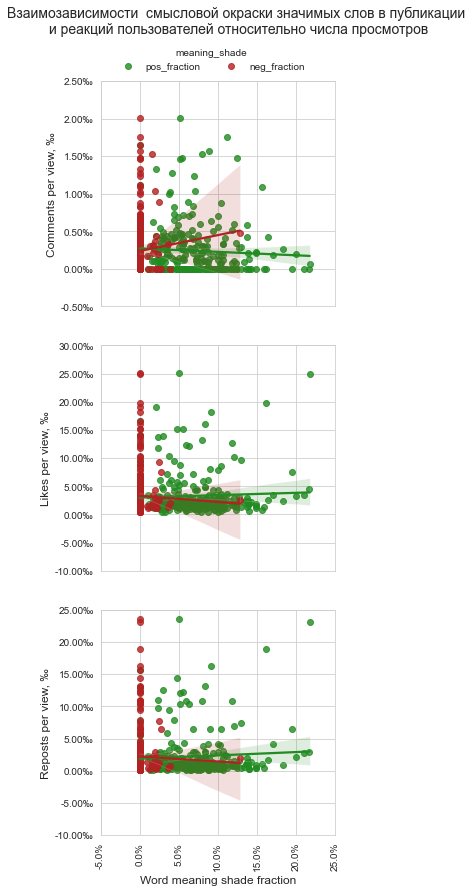

In [83]:
g = sns.PairGrid(data=df_222d, 
                 y_vars=["comments_per_view", "likes_per_view", "reposts_per_view"],
                 x_vars="fraction",
                 hue="meaning_shade",
                 height=4,
                 aspect=1.2,
                 palette={"pos_fraction":"forestgreen", "neg_fraction":"firebrick"},
                 layout_pad=3,
                 despine=False
                )

plt.suptitle(f"Взаимозависимости  смысловой окраски значимых слов в публикации \n"
             f"и реакций пользователей относительно числа просмотров",x=0.45,  y=1.0375, fontsize=14)
g.map(sns.regplot)
g.add_legend(ncol=2, loc='upper center', bbox_to_anchor=(0.15, 0.5, 0.5, 0.5))

# Устанавливаем размерность в % для оси X
# а) исправляем User Warning: FixedFormatter should only be used together with FixedLocator заново устанавливае yticks
ticks_loc = g.axes[1][0].get_xticks().tolist()
g.axes[2][0].set_xticks(ticks_loc)
# б) устанавливаем формат и значения
x_t_labels = [f"{(x * 100):.1f}%" for x in ticks_loc]
g.axes[2][0].set_xticklabels(x_t_labels, fontsize=10, rotation=90)
g.axes[2][0].set_xlabel("Word meaning shade fraction", fontsize=12)

# изменим параметры оси Y
label_list=["Comments per view, ‰", "Likes per view, ‰", "Reposts per view, ‰"]
for i, y_axis_label in enumerate(label_list):
    # а) исправляем User Warning: FixedFormatter should only be used together with FixedLocator заново устанавливае yticks
    ticks_loc = g.axes[i][0].get_yticks().tolist()
    g.axes[i][0].set_yticks(ticks_loc)
    # б) устанавливаем формат и значения
    y_t_labels = [f"{(y * 1000):.2f}‰" for y in ticks_loc]
    g.axes[i][0].set_yticklabels(y_t_labels, fontsize=10)
    g.axes[i][0].set_ylabel(y_axis_label, fontsize=12)

plt.show()

**ВЫВОД**  
Анализ графиков линейной регрессии зависимостей реакций пользователей от доли слов с положительной и отрицательной смысловой окраской в публикациях показывает следующее.
1. Тексты с отрицательной смысловой окраской:
- большинство реакций пользователей приходятся на публикации с нулевой степенью негативности;
- количество комментариев в отношении к числу просмотров имеет тенденцию к увеличению с ростом доли негативных слов в тексте, но доверительный интервал здесь очень большой;
- также с низкой степенью доверия выявляется тенденция к уменьшению репостов и "лайков" в отношении к числу просмотров параллельно увлечению степени негативности текста.
Указанные тенденции для текстов с отрицательной смысловой окраской вполне ожидаемы и объяснимы.
2. Тексты с положительной смысловой (здесь зависимости с точностью "до наоборот":
- большинство текстов с положительной смысловой окраской вызывают близкую к 0 реакцию пользователей;
- отношение комментариев к числу просмотров имеет свойство падать с ростом концентрации позитивных слов в публикациях, причем с гораздо большей степенью доверия, чем в случае с негативными словами;
- количество "лайков" и репостов, имеют слабую тенденцию к увеличению с ростом позитивности текстов.
3. Можно предположить, что аудитория стены Skillbox в VK состоит из большого числа "полярных ответчиков" (в части желания оставить комментарии). Для них отрицательный стимул приводит к положительной реакции. Чем негативнее текст, тем больше желание написать комментарий. Возможно. Но для однозначного вывода пока данных недостаточно.


## ОСНОВНЫЕ ВЫВОДЫ ##
(остальные моменты приведены после каждого раздела в тексте работы)  

Изучение данных о публикация Skillbox на стене в "ВКонтаке" позволяет выделить следующие вопросы, проблемы и тенденции, которые требуют внимания со стороны SMM-отдела компании.  
  
***Анализ публикаций по формальным критериям***
1. Размещение публикаций Skillbox на стене в VK не всегда производится ежедневно. Снижение интенсивности публикаций в период новогодних праздников, когда читатели имеют больше времени, чтобы получать информацию из Интернета, представляется странным. Также, в период посленовогодних скидок, интенсивность публикаций могла бы быть выше (здесь нет дней, когда публиковалось более 2 публикаций).
2. На протяжении всего периода отмечается тенденция к уменьшению количества публикаций в день. 
3. Наибольшее количество просмотров (помимо дней, когда было много публикаций), относятся к публикациям с обещанием бесплатных курсов, вебинаров, программ, а также бонусов и распродаж; еще одна группа причин: высокая актуальность темы; третья группа - свободное время у пользователей для просмотра новой информации. Создаётся впечатление, что все эти моменты (кроме, разве что бесплатных мероприятий) недостаточно используются для продвижения своих услуг.
4. На 28% из 185 дней с публикациями не приходится ни одного комментария. В целом уровень комментариев очень низкий. Они также стимулируются использованием тематики, указанной в п.3. 
5. Общая динамика графиков «лайков» и репостов схожа с графиком просмотров. Способы увеличения их те же, что указаны выше.
6. Чётко проявляется постепенное снижение активности читателей стены в течение 4-го квартала 2021 года, некоторое оживление в посленовогодний период, пауза в первые 10 дней с момента начала специальной военной операции, оживление с середины марта до настоящего времени, возможно, связанное с ослаблением ковидных ограничений.
7. Наибольшее количество публикаций приходится на будние дни, причём их количество возрастает к пятнице. В субботу и воскресенье (когда у пользователей больше времени читать-!) публикаций значительно меньше. 
8. Просмотров субботних и воскресных публикаций существенно меньше, чем в другие дни (но и публикаций меньше - нечего просматривать).
9. Анализ соотношения реакций пользователей к числу просмотров показывает всё те же стимулы в тексте: анонс бесплатных курсов, вебинаров, программ, а также бонусов и распродаж; высокая актуальность темы; свободное время у пользователей для просмотра новой информации. Это необходимо использовать. Здесь также надо обратить внимание на рост реакций пользователей к числу просмотров для публикаций, размещённых в выходные дни, обеденное время и вечером, по окончании рабочего дня.  
  

***Анализ публикаций по смысловому содержанию***
1. Максимальное количество публикаций не имеет тематического тэга - их более 100. Однако, по смыслу, публикации легко классифицируются по имеющимся тэгам, но по неизвестной причине тэг в них отсутствует. Никакой системности в пропуске тэгов не выявляется. Такая ситуация может быть связана: с программными ошибками, неаккуратностью при осуществлении публикации, какими-то упущениями или нарушениями регламента осуществления публикаций.

2. Количество публикаций по тэгам недостаточно учитывает их популярность при просмотрах. Более популярные тэги требуют большего количества публикаций. Недостаточным учётом популярности тэгов можно объяснить большое количество просмотров и реакций на них для, казалось бы, непримечательных публикаций.
3. Комментарии и «лайки» с репостами по-разному соотносятся с тэгами публикаций. Это необходимо учитывать при формировании тематики публикаций и в зависимости от ожидаемого эффекта.
4. Общий словарь значимых слов, использованный при составлении публикаций, составляет 3672 слова. Это не очень много с точки зрения лексического многообразия русского языка.
5. Есть слова, используемые слишком часть от 21 до 192 раз. На это следует обратить внимание.  Таких слов 113. Некоторые из них встречаются внутри одного и того же сообщения не по одному разу.
6. Половина публикаций имеет среднюю встречаемость слов на уровне более 31 раза. Это очень высокий показатель.  Большое количество публикаций с высокой средней встречаемостью слов говорит о том, что при их подготовке не было уделено внимание словесному многообразию, мало использовались синонимы. Скорее всего, такие публикации готовились формально, по шаблону, тексты в них стандартизованы и упрощены в ущерб красноречию. 
7. Лучшими с точки зрения низкой встречаемости значимых слов, являются публикации, размещённые в среду. Худшими - в субботу и особенно в воскресенье. Возможно, именно в эти дне характерен более формальный нежели творческий подход к составлению текстов.
8. Отмечается отрицательная зависимость «лайков» и репостов к просмотрам по отношению к средней встречаемости слов в публикациях: чем больше средняя встречаемость, тем меньше отметок, что публикация понравилась в отношении к просмотрам; такое явление вряд ли носит осознанный характер, но, скорее всего, пользователи интуитивно предпочитают более красноречивые сообщения.
9. Доля позитивных слов, используемых в публикациях, составляет 4,63% от общего состава значимых слов в массиве публикаций. Определяются очень низкие показатели встречаемости позитивных слов. Можно предположить, что позитивности письменной речи, системному употреблению отрицаний и суггестивности уделяется недостаточно внимания.
10. В целом сообщения характеризуются избеганием негативной смысловой окраски - это хороший признак. Но это происходит не всегда.
11. Средняя степень позитивности публикаций колеблется от 0 до 24%. При этом большая доля публикаций имеет степень позитивности на уровне до 1%. В диапазоне от 15% до 24% степени позитивности находятся единичные публикации. Желательно было бы повысить число публикаций с высокой степенью использования позитивных слов.
12. Публикации, содержащие негативные слова составляют 7,2% всех публикаций. Средняя степень негативности публикаций колеблется от 0 до 13%. Есть 1 публикация со степенью негативности 13%. В целом, это хорошие показатели.
13. Необходимо учитывать следующие моменты:
- количество комментариев в отношении к числу просмотров имеет тенденцию к увеличению с ростом доли негативных слов в тексте;
- выявляется тенденция к уменьшению репостов и "лайков" в отношении к числу просмотров параллельно увлечению степени негативности текста.
- большинство текстов с положительной смысловой окраской вызывают близкую к 0 реакцию пользователей (что на самом деле странно);
- отношение комментариев к числу просмотров имеет свойство падать с ростом концентрации позитивных слов в публикациях;
- количество "лайков" и репостов, имеют тенденцию к увеличению с ростом позитивности текстов.
- можно предположить, что аудитория стены Skillbox в VK состоит из большого числа "полярных ответчиков" (в части желания оставить комментарии): отрицательный стимул приводит к положительной реакции, чем негативнее текст, тем больше желание написать комментарий. 
14. Важно отметить, что судить об эффективности публикаций стоит не по просмотрам, комментариям, лайкам и репостам, а по росту числа студентов. Но для этого нужно проводить отдельное исследование.

In [84]:
pd.set_option('display.max_rows', 60)  # восстановим значение по умолчанию максимума отображаемых строк 
pd.set_option('display.max_columns', 20)  # восстановим значение по умолчанию максимума отображаемых столбцов